# STAT486 Pairs Trading Final Project

In [ ]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts


In [ ]:
coke = yf.download('KO','2021-03-01','2024-03-01')
pepsi = yf.download('PEP','2021-03-01','2024-03-01')
coke_price = coke['Adj Close']
pepsi_price = pepsi['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
y = np.log(coke_price)
x = np.log(pepsi_price)
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
results.params

const        0.111307
Adj Close    0.772852
dtype: float64

In [ ]:
x

,const,Adj Close
Date,,
2009-03-02,1.0,3.399785
2009-03-03,1.0,3.433779
2009-03-04,1.0,3.424474
2009-03-05,1.0,3.389630
2009-03-06,1.0,3.413914
...,...,...
2024-02-23,1.0,5.125840
2024-02-26,1.0,5.117908
2024-02-27,1.0,5.117314


In [ ]:
alpha = results.params.values[0]
beta = results.params.values[1]
errors = y - (alpha + x['Adj Close']*beta)
errors

Date
2009-03-02   -0.226045
2009-03-03   -0.274223
2009-03-04   -0.244118
2009-03-05   -0.265665
2009-03-06   -0.251941
                ...   
2024-02-23    0.033357
2024-02-26    0.031449
2024-02-27    0.025795
2024-02-28    0.032000
2024-02-29    0.027672
Name: Adj Close, Length: 3776, dtype: float64

<Axes: xlabel='Date'>

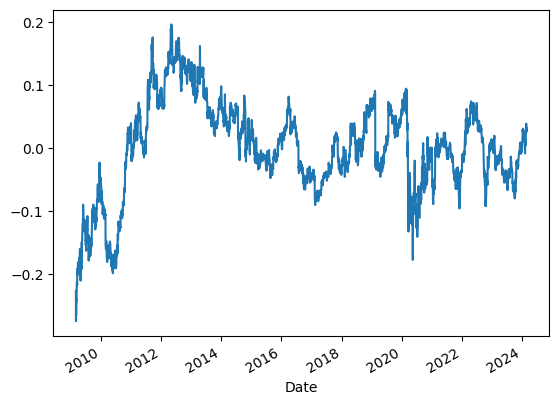

In [ ]:
errors.plot()

In [ ]:
result = ts.coint(coke_price, pepsi_price)
print(result)

(-4.106134711993868, 0.005038799572572365, array([-3.89934352, -3.33774905, -3.04557369]))


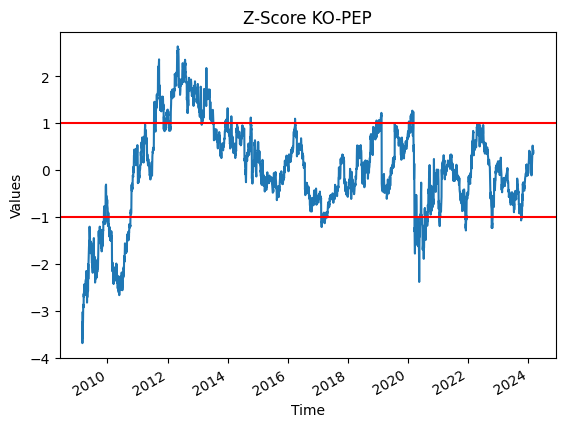

In [ ]:
spread = errors
zscore = (spread - np.mean(spread)) / np.std(spread)
zscore.plot(label='z-score')
plt.title(f"Z-Score KO-PEP")
plt.xlabel('Time')
plt.ylabel('Values')
plt.axhline(y=1, color='r')
plt.axhline(y=-1, color='r')

# Functions

In [ ]:
def backtest_pairs(signal_entry, signal_exit, stock1, stock2):
  s1 = yf.download(stock1,'2021-03-01','2024-03-01')
  s2 = yf.download(stock2,'2021-03-01','2024-03-01')
  s1_price = s1['Adj Close']
  s2_price = s2['Adj Close']

  y = np.log(s1_price)
  x = np.log(s2_price)
  x = sm.add_constant(x)
  model = sm.OLS(y,x)
  results = model.fit()

  alpha = results.params.values[0]
  beta = results.params.values[1]
  errors = y - (alpha + x['Adj Close']*beta)

  spread = errors
  zscore = (spread - np.mean(spread)) / np.std(spread)

  # create df
  backtest = pd.DataFrame()
  backtest[stock1] = s1_price
  backtest[stock2] = s2_price
  backtest['Z-Score'] = zscore
  backtest['Short Entry'] = (zscore > signal_entry) & (zscore.shift(1) < signal_entry)
  backtest['Short Exit'] = (zscore < signal_exit) & (zscore.shift(1) > signal_exit)
  backtest['Long Entry'] = (zscore < -signal_entry) & (zscore.shift(1) > -signal_entry)
  backtest['Long Exit'] = (zscore > -signal_exit) & (zscore.shift(1) < -signal_exit)
  return backtest

def backtest_pairs_performance(backtest, stock1, stock2):
  short_start_ko, short_start_pep = 0, 0
  long_start_ko, long_start_pep = 0, 0
  long_returns1, short_returns1 = [], []
  long_returns1_percent, short_returns1_percent = 1, 1
  short_returns1_val, long_returns1_val = [], []
  cnt1, cnt2 = 0, 0
  for index, row in backtest.iterrows():
    if row['Short Entry']:
      # long KO, short PEP
      short_start_pep = row[stock2]
      long_start_ko = row[stock1]
    if row['Short Exit']:
      if short_start_pep != 0:
        short_returns1_val.append(short_start_pep - row[stock2])

        percent_return = (short_start_pep - row[stock2])/short_start_pep
        short_returns1.append(percent_return)
      if long_start_ko != 0:
        long_returns1_val.append(row[stock1] - long_start_ko)

        percent_return = (row[stock1] - long_start_ko)/long_start_ko
        long_returns1.append(percent_return)

    if row['Long Entry']:
      # short KO, long PEP
      short_start_ko = row[stock1]
      long_start_pep = row[stock2]
    if row['Long Exit']:
      if short_start_ko != 0:
        short_returns1_val.append(short_start_ko - row[stock1])

        percent_return = (short_start_ko - row[stock1])/short_start_ko
        short_returns1.append(percent_return)
      if long_start_pep != 0:
        long_returns1_val.append(row[stock2] - long_start_pep)

        percent_return = (row[stock2] - long_start_pep)/long_start_pep
        long_returns1.append(percent_return)

  total_returns1 = [num for num in short_returns1]
  total_returns1.extend([num for num in long_returns1])

  cum_return = 1
  cum_returns = []
  for num in total_returns1:
    cum_return *= (1+num)
    cum_returns.append(cum_return)
  print()
  print('Cumulative Return: ', cum_return-1)

  mean_total_returns, std_total_returns = np.mean(total_returns1), np.std(total_returns1)
  risk_free_rate = 0.04
  sharpe_ratio = ((cum_return-1)-risk_free_rate)/std_total_returns

  pos_returns = [num for num in total_returns1 if num>0]
  neg_returns = [num for num in total_returns1 if num<0]
  print('Average Win: ', np.mean(pos_returns))
  print('Average Loss: ', np.mean(neg_returns))

  i = np.argmax(np.maximum.accumulate(cum_returns) - cum_returns) # end of the period
  j = np.argmax(cum_returns[:i]) # start of period

  #print([i, j], [cum_returns[i], cum_returns[j]])
  print('Max Drawdown: ', (cum_returns[i]-cum_returns[j])/cum_returns[j])
  print('Sharpe Ratio: ', sharpe_ratio)
  return cum_return-1, sharpe_ratio, total_returns1

In [ ]:
df1 = backtest_pairs(0.8, 0.7, 'MS', 'GS')
df1

In [ ]:
cum_return, sharpe_ratio, total_returns = backtest_pairs_performance(df1, 'MS', 'GS')


Cumulative Return:  -0.3715060057644768
Average Win:  0.06528260329328166
Average Loss:  -0.06088546390801185
Max Drawdown:  -0.60505633885563
Sharpe Ratio:  -4.56163154022678


In [ ]:
cum_return = 1
cum_returns_plot = []
for num in total_returns:
  print('num: ', num)
  cum_return *= (1+num)
  cum_returns_plot.append(cum_return)
plt.plot(cum_returns_plot)

# Metrics

In [ ]:
df1 = backtest_pairs(1.1, 0.2, 'JNJ', 'AMGN')
cum_return, sharpe_ratio, total_returns = backtest_pairs_performance(df1, 'JNJ', 'AMGN')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  1.2284688568878779
Average Win:  0.11343775125142774
Average Loss:  -0.05614274583240073
Max Drawdown:  -0.2858726892399141
Sharpe Ratio:  11.906160948238336


In [ ]:
total_returns

# GridSearch

In [ ]:
res = []
for i in [0.7,0.8,0.9,1,1.1,1.2]:
  for j in [0.2,0.3,0.4,0.5,0.6,0.7]:
    if i > j:
      print()
      df1 = backtest_pairs(i, j, 'JNJ', 'AMGN')
      print(i,j)
      cum_return, sharpe_ratio, total_returns = backtest_pairs_performance(df1, 'JNJ', 'AMGN')
      res.append((i,j,cum_return,sharpe_ratio))

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


0.7 0.2


[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.6377183239525146
Average Win:  0.09059632761966842
Average Loss:  -0.044805437173027055
Max Drawdown:  -0.48841569806087015
Sharpe Ratio:  7.56146166206843




[*********************100%%**********************]  1 of 1 completed


0.7 0.3


[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.6543469544702398
Average Win:  0.08692165544406784
Average Loss:  -0.04037318966142452
Max Drawdown:  -0.47089320040976335
Sharpe Ratio:  8.248427187256054




[*********************100%%**********************]  1 of 1 completed


0.7 0.4


[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.5657955982118352
Average Win:  0.08512288341082544
Average Loss:  -0.038035611987662615
Max Drawdown:  -0.5110366212293465
Sharpe Ratio:  7.153976026225934




[*********************100%%**********************]  1 of 1 completed


0.7 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.21196515260143678
Average Win:  0.06690255466612709
Average Loss:  -0.031040813763864618
Max Drawdown:  -0.3789758090554196
Sharpe Ratio:  -4.174706997087912



0.7 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.22796188447637034
Average Win:  0.05350440160678447
Average Loss:  -0.025776155839574242
Max Drawdown:  -0.3183622809886441
Sharpe Ratio:  -5.058093366332144

0.8 0.2



[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.7246559123287422
Average Win:  0.0884294601543883
Average Loss:  -0.046271786036638764
Max Drawdown:  -0.4948386290456519
Sharpe Ratio:  8.57133502504397




[*********************100%%**********************]  1 of 1 completed


0.8 0.3


[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.6985833157245185
Average Win:  0.0864874613193057
Average Loss:  -0.0412419299751247
Max Drawdown:  -0.5345267466283578
Sharpe Ratio:  8.89695490420633




[*********************100%%**********************]  1 of 1 completed


0.8 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.5857705306350671
Average Win:  0.08565870560253823
Average Loss:  -0.03964733420818524
Max Drawdown:  -0.5494573887316869
Sharpe Ratio:  7.434863647916957

0.8 0.5



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.2007146467075882
Average Win:  0.06668551112718803
Average Loss:  -0.034137912896128685
Max Drawdown:  -0.5006781265632476
Sharpe Ratio:  -3.9204605597899462

0.8 0.6



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.30463773219564017
Average Win:  0.056264080008679225
Average Loss:  -0.028341252258825184
Max Drawdown:  -0.3640316740598598
Sharpe Ratio:  -6.4139938792956315

0.8 0.7



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.41555605611978064
Average Win:  0.026524367236219527
Average Loss:  -0.02346586400226777
Max Drawdown:  -0.48462242579065495
Sharpe Ratio:  -14.274461984439341

0.9 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.5904654139863308
Average Win:  0.09007823139358409
Average Loss:  -0.05124903267311576
Max Drawdown:  -0.5022678035153294
Sharpe Ratio:  6.663899629674217

0.9 0.3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.5367090521199069
Average Win:  0.08417789371432027
Average Loss:  -0.04656959469646636
Max Drawdown:  -0.5583155770629848
Sharpe Ratio:  6.51147244445598

0.9 0.4



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.5249167872453808
Average Win:  0.08357954571197657
Average Loss:  -0.043409944219416186
Max Drawdown:  -0.506786725050183
Sharpe Ratio:  6.450997585151495

0.9 0.5



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.12057652787848605
Average Win:  0.06834490724090238
Average Loss:  -0.03678743418208418
Max Drawdown:  -0.44726107419373223
Sharpe Ratio:  -2.5000331513689824

0.9 0.6



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.17108830945789533
Average Win:  0.060601809788034394
Average Loss:  -0.0318069443135589
Max Drawdown:  -0.3157358455739223
Sharpe Ratio:  -3.643822575496694

0.9 0.7



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.39538247060938647
Average Win:  0.034947770608147063
Average Loss:  -0.02621976067460682
Max Drawdown:  -0.50802857371422
Sharpe Ratio:  -11.376484658032444

1 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.4260469577218813
Average Win:  0.08685304552191679
Average Loss:  -0.049085889248199836
Max Drawdown:  -0.34437632454404665
Sharpe Ratio:  4.9884980187491355

1 0.3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.34366697001028146
Average Win:  0.0887548874055608
Average Loss:  -0.04475323518323579
Max Drawdown:  -0.4750263056954386
Sharpe Ratio:  4.1215674598437175

1 0.4



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.3684597681852617
Average Win:  0.08692894909504652
Average Loss:  -0.043084574647787095
Max Drawdown:  -0.48206828196526985
Sharpe Ratio:  4.488249475378963

1 0.5



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.10864684464969043
Average Win:  0.07573537903141139
Average Loss:  -0.03653440790383247
Max Drawdown:  -0.4644208023028607
Sharpe Ratio:  -2.3896287076839493

1 0.6



[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.09746118397904557
Average Win:  0.06270322310571737
Average Loss:  -0.033204687394530266
Max Drawdown:  -0.32758499003650965
Sharpe Ratio:  -2.419284535788044




[*********************100%%**********************]  1 of 1 completed


1 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.37430617803477173
Average Win:  0.03566389850979123
Average Loss:  -0.030304492490388378
Max Drawdown:  -0.4437356442882062
Sharpe Ratio:  -10.921117795539683

1.1 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  1.2284703657840184
Average Win:  0.11343777551693071
Average Loss:  -0.05614274679910115
Max Drawdown:  -0.2858727675096611
Sharpe Ratio:  11.906173591450312

1.1 0.3

Cumulative Return:  0.9232224993910862
Average Win:  0.1118160109792524
Average Loss:  -0.05232311243606737
Max Drawdown:  -0.6150022261954186
Sharpe Ratio:  9.121909354691782




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.4

Cumulative Return:  0.9365413260505819
Average Win:  0.1081000280091512
Average Loss:  -0.04991412396506686
Max Drawdown:  -0.5962700832478931
Sharpe Ratio:  9.44849507106709

1.1 0.5

Cumulative Return:  -0.11009753756819707
Average Win:  0.09581218292129595
Average Loss:  -0.04219966342101918
Max Drawdown:  -0.6038139613550813
Sharpe Ratio:  -1.8786985597017836



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.6

Cumulative Return:  -0.2777392357502052
Average Win:  0.07874310629123131
Average Loss:  -0.04198880365075272
Max Drawdown:  -0.4848148370684183
Sharpe Ratio:  -4.165098756891207



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.7

Cumulative Return:  -0.5354522399774735
Average Win:  0.047222087051579716
Average Loss:  -0.04017814974041549
Max Drawdown:  -0.6025858744225862
Sharpe Ratio:  -9.592719515975158



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.2

Cumulative Return:  0.21518950778598644
Average Win:  0.1348055318181211
Average Loss:  -0.05650768279534937
Max Drawdown:  -0.6959219820252026
Sharpe Ratio:  1.668630107598075

1.2 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  0.056474645840731474
Average Win:  0.1259586213191154
Average Loss:  -0.054746498764153405
Max Drawdown:  -0.7882723027444483
Sharpe Ratio:  0.1610154067187804

1.2 0.4



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.03413790693845309
Average Win:  0.1217471646450447
Average Loss:  -0.053223058571401964
Max Drawdown:  -0.7830561033694428
Sharpe Ratio:  -0.058003977845678324

1.2 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.5753368945084715
Average Win:  0.11244166191040068
Average Loss:  -0.04804480938446116
Max Drawdown:  -0.7779922043351037
Sharpe Ratio:  -7.174387799542344

1.2 0.6

Cumulative Return:  -0.6426776120778053
Average Win:  0.10729204530396425
Average Loss:  -0.04484139640218143
Max Drawdown:  -0.6719480629569765
Sharpe Ratio:  -8.39270299321462




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.7

Cumulative Return:  -0.7475800354847606
Average Win:  0.0802756615678287
Average Loss:  -0.04411349148778334
Max Drawdown:  -0.8215573017367247
Sharpe Ratio:  -11.168594173199976


In [ ]:
sorted(res, key=lambda x: x[2], reverse=True)

[(1.1, 0.2, 1.2284703657840184, 11.906173591450312),
 (1.1, 0.4, 0.9365413260505819, 9.44849507106709),
 (1.1, 0.3, 0.9232224993910862, 9.121909354691782),
 (0.8, 0.2, 0.7246559123287422, 8.57133502504397),
 (0.8, 0.3, 0.6985833157245185, 8.89695490420633),
 (0.7, 0.3, 0.6543469544702398, 8.248427187256054),
 (0.7, 0.2, 0.6377183239525146, 7.56146166206843),
 (0.9, 0.2, 0.5904654139863308, 6.663899629674217),
 (0.8, 0.4, 0.5857705306350671, 7.434863647916957),
 (0.7, 0.4, 0.5657955982118352, 7.153976026225934),
 (0.9, 0.3, 0.5367090521199069, 6.51147244445598),
 (0.9, 0.4, 0.5249167872453808, 6.450997585151495),
 (1, 0.2, 0.4260469577218813, 4.9884980187491355),
 (1, 0.4, 0.3684597681852617, 4.488249475378963),
 (1, 0.3, 0.34366697001028146, 4.1215674598437175),
 (1.2, 0.2, 0.21518950778598644, 1.668630107598075),
 (1.2, 0.3, 0.056474645840731474, 0.1610154067187804),
 (1.2, 0.4, 0.03413790693845309, -0.058003977845678324),
 (1, 0.6, -0.09746118397904557, -2.419284535788044),
 (1, 0.5,

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


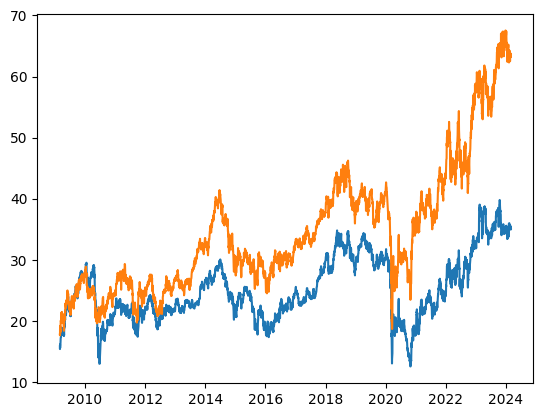

In [ ]:
s1 = yf.download('CVX','2009-03-01','2024-03-01')
s2 = yf.download('XOM','2009-03-01','2024-03-01')
s1_price = coke['Adj Close']
s2_price = pepsi['Adj Close']

plt.plot(s1.index, s1_price, label='KO Price')
plt.plot(s2.index, s2_price, label='PEP Price')

In [ ]:
# res = []
# for i in [0.7,0.8,0.9,1,1.1,1.2]:
#   for j in [0.2,0.3,0.4,0.5,0.6,0.7]:
#     if i > j:
#       print()
#       df1 = backtest_pairs(i, j, 'CVX', 'XOM')
#       print(i,j)
#       cum_return, sharpe_ratio = backtest_pairs_performance(df1)
#       res.append((i,j,cum_return,sharpe_ratio))

# Plots

In [ ]:
signal_entry = 1
signal_exit = 0.5

backtest = pd.DataFrame()
backtest['KO'] = coke_price
backtest['PEP'] = pepsi_price
backtest['Z-Score'] = zscore
backtest['Short Entry'] = (zscore > signal_entry) & (zscore.shift(1) < signal_entry)
backtest['Short Exit'] = (zscore < signal_exit) & (zscore.shift(1) > signal_exit)
backtest['Long Entry'] = (zscore < -signal_entry) & (zscore.shift(1) > -signal_entry)
backtest['Long Exit'] = (zscore > -signal_exit) & (zscore.shift(1) < -signal_exit)
backtest

In [ ]:
short_start_ko, short_start_pep = 0, 0
long_start_ko, long_start_pep = 0, 0
long_returns1, short_returns1 = [], []
long_returns1_percent, short_returns1_percent = 1, 1
short_returns1_val, long_returns1_val = [], []
cnt1, cnt2 = 0, 0
for index, row in backtest.iterrows():
  if row['Short Entry']:
    # long KO, short PEP
    short_start_pep = row['PEP']
    long_start_ko = row['KO']
  if row['Short Exit']:
    if short_start_pep != 0:
      short_returns1_val.append(short_start_pep - row['PEP'])

      percent_return = (short_start_pep - row['PEP'])/short_start_pep
      short_returns1.append(percent_return)
    if long_start_ko != 0:
      long_returns1_val.append(row['KO'] - long_start_ko)

      percent_return = (row['KO'] - long_start_ko)/long_start_ko
      long_returns1.append(percent_return)

  if row['Long Entry']:
    # short KO, long PEP
    short_start_ko = row['KO']
    long_start_pep = row['PEP']
  if row['Long Exit']:
    if short_start_ko != 0:
      short_returns1_val.append(short_start_ko - row['KO'])

      percent_return = (short_start_ko - row['KO'])/short_start_ko
      short_returns1.append(percent_return)
    if long_start_pep != 0:
      long_returns1_val.append(row['PEP'] - long_start_pep)

      percent_return = (row['PEP'] - long_start_pep)/long_start_pep
      long_returns1.append(percent_return)

total_returns1 = [num for num in short_returns1]
total_returns1.extend([num for num in long_returns1])

cum_return = 1
cum_returns = []
for num in total_returns1:
  cum_return *= (1+num)
  cum_returns.append(cum_return)
cum_return

In [ ]:
mean_total_returns, std_total_returns = np.mean(total_returns1), np.std(total_returns1)
risk_free_rate = 0.04
sharpe_ratio = (mean_total_returns-risk_free_rate)/std_total_returns

pos_returns = [num for num in total_returns1 if num>0]
neg_returns = [num for num in total_returns1 if num<0]
print('Average Win: ', np.mean(pos_returns))
print('Average Loss: ', np.mean(neg_returns))

i = np.argmax(np.maximum.accumulate(cum_returns) - cum_returns) # end of the period
j = np.argmax(cum_returns[:i]) # start of period

#print([i, j], [cum_returns[i], cum_returns[j]])
print('Max Drawdown: ', (cum_returns[i]-cum_returns[j])/cum_returns[j])

print()
print('Sharpe Ratio: ', sharpe_ratio)

In [ ]:
df1

,JNJ,AMGN,Z-Score,Short Entry,Short Exit,Long Entry,Long Exit
Date,,,,,,,
2021-03-01,146.767487,206.254257,-1.520335,False,False,False,False
2021-03-02,146.491135,205.027878,-1.551429,False,False,False,False
2021-03-03,143.911697,203.438080,-1.954663,False,False,False,False
2021-03-04,141.009918,201.593933,-2.416606,False,False,False,False
2021-03-05,143.801178,206.881104,-2.011034,False,False,False,False
...,...,...,...,...,...,...,...
2024-02-23,161.839996,289.179993,0.027462,False,False,False,False
2024-02-26,160.789993,286.369995,-0.104560,False,False,False,False
2024-02-27,160.979996,278.489990,-0.013120,False,False,False,False


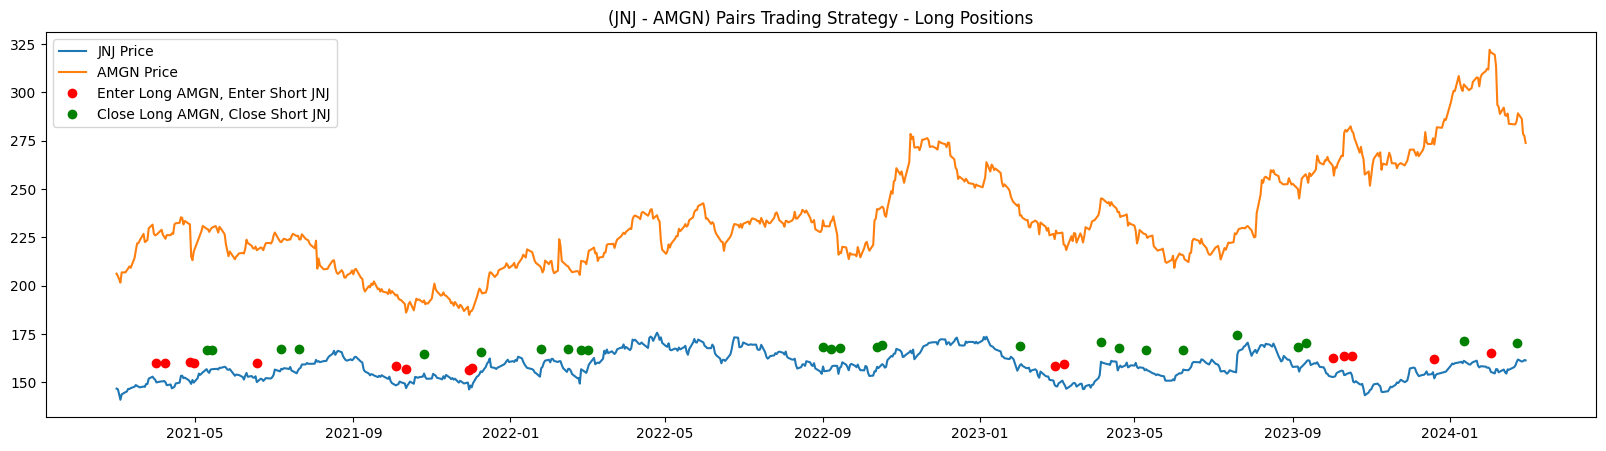

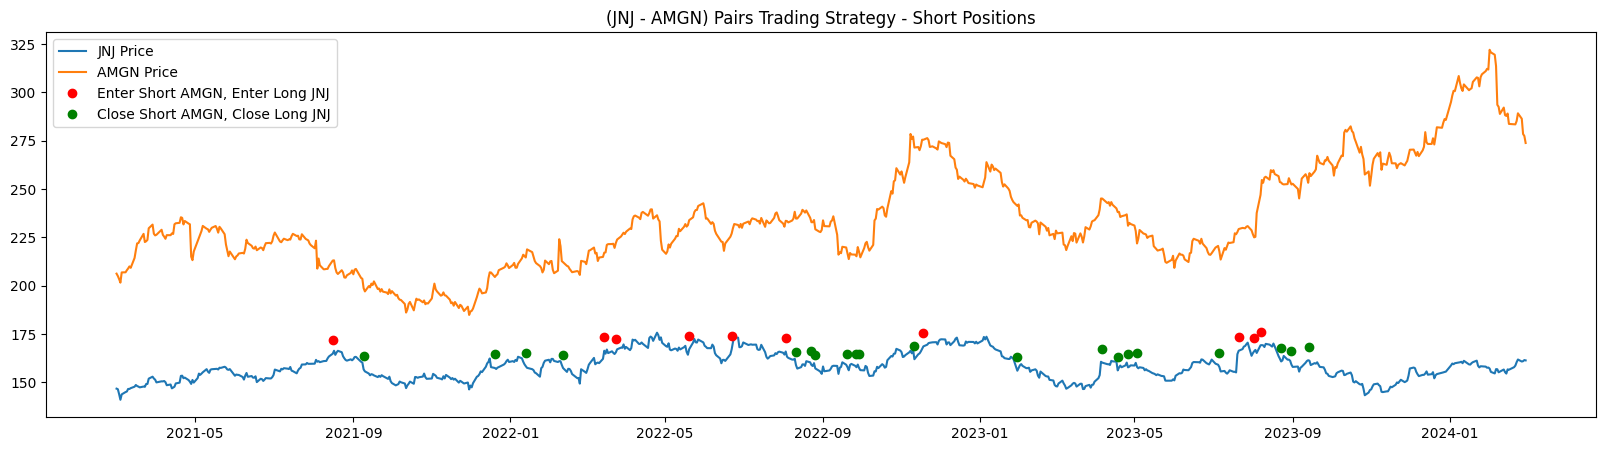

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(df1.index, df1['JNJ'], label='JNJ Price')
plt.plot(df1.index, df1['AMGN'], label='AMGN Price')
first_enter, first_close = True, True
for index, row in df1.iterrows():
  if row['Long Entry']:
    if first_enter:
      plt.plot(index, row['JNJ']+10, 'ro', label='Enter Long AMGN, Enter Short JNJ')
      first_enter = False
    else:
      plt.plot(index, row['JNJ']+10, 'ro')

  if row['Long Exit']:
    if first_close:
      plt.plot(index, row['JNJ']+10, 'go', label='Close Long AMGN, Close Short JNJ')
      first_close = False
    else:
      plt.plot(index, row['JNJ']+10, 'go')
plt.title('(JNJ - AMGN) Pairs Trading Strategy - Long Positions')
plt.legend()

# ======
plt.figure(figsize=(20,5))

plt.plot(df1.index, df1['JNJ'], label='JNJ Price')
plt.plot(df1.index, df1['AMGN'], label='AMGN Price')
first_enter, first_close = True, True
for index, row in df1.iterrows():
  if row['Short Entry']:
    if first_enter:
      plt.plot(index, row['JNJ']+7, 'ro', label='Enter Short AMGN, Enter Long JNJ')
      first_enter = False
    else:
      plt.plot(index, row['JNJ']+7, 'ro')

  if row['Short Exit']:
    if first_close:
      plt.plot(index, row['JNJ']+7, 'go', label='Close Short AMGN, Close Long JNJ')
      first_close = False
    else:
      plt.plot(index, row['JNJ']+7, 'go')
plt.title('(JNJ - AMGN) Pairs Trading Strategy - Short Positions')
plt.legend()

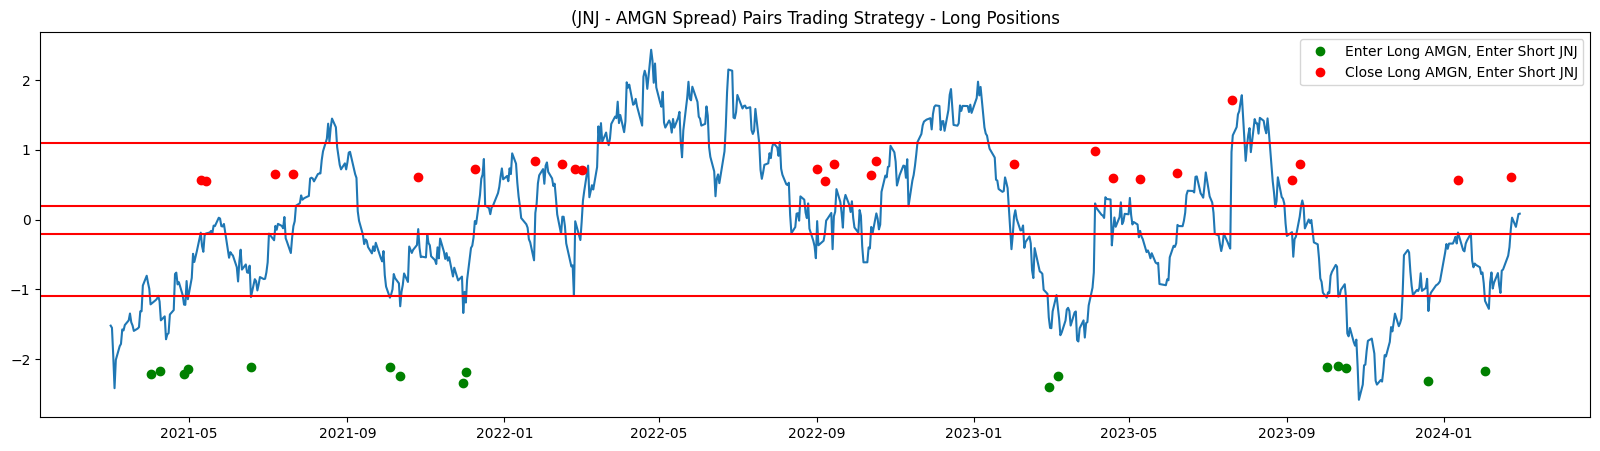

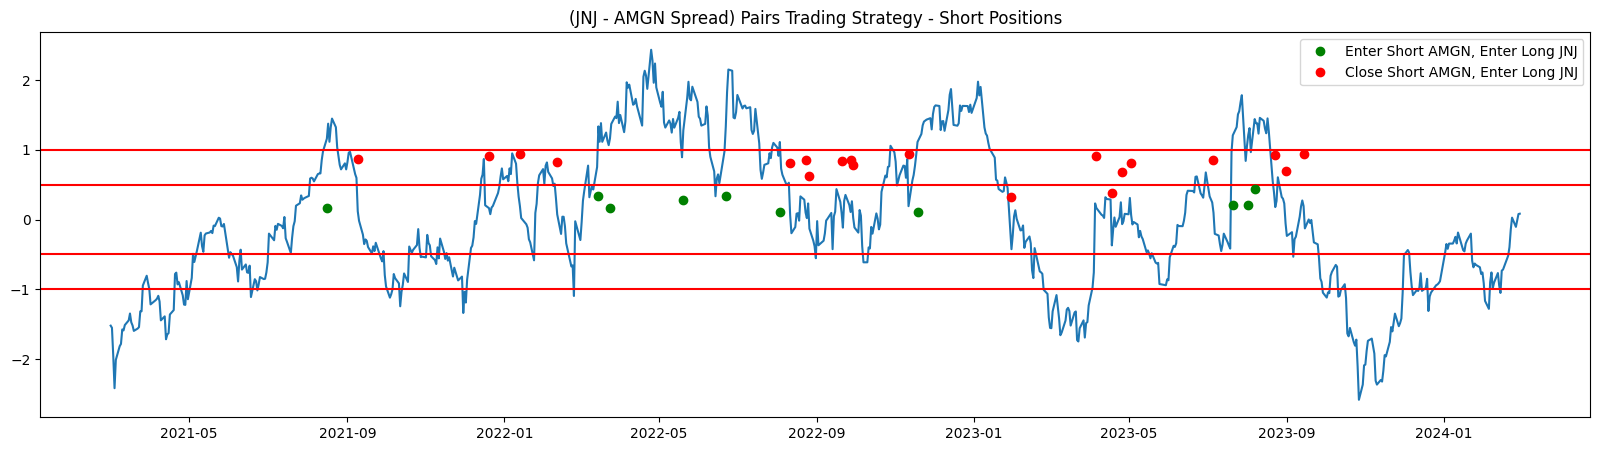

In [ ]:
plt.figure(figsize=(20,5))

zscore = df1['Z-Score']
plt.plot(zscore)
plt.axhline(y = 1.1, color = 'r', linestyle = '-')
plt.axhline(y = -1.1, color = 'r', linestyle = '-')
plt.axhline(y = 0.2, color = 'r', linestyle = '-')
plt.axhline(y = -0.2, color = 'r', linestyle = '-')
first_enter, first_close = True, True
for index, row in df1.iterrows():
  if row['Long Entry']:
    if first_enter:
      plt.plot(index, zscore[index]-1, 'go', label='Enter Long AMGN, Enter Short JNJ')
      first_enter = False
    else:
      plt.plot(index, zscore[index]-1, 'go')

  if row['Long Exit']:
    if first_close:
      plt.plot(index, zscore[index]+0.75, 'ro', label='Close Long AMGN, Enter Short JNJ')
      first_close = False
    else:
      plt.plot(index, zscore[index]+0.75, 'ro')
plt.title('(JNJ - AMGN Spread) Pairs Trading Strategy - Long Positions')
plt.legend()

# =====
plt.figure(figsize=(20,5))

plt.plot(zscore)
plt.axhline(y = 1, color = 'r', linestyle = '-')
plt.axhline(y = -1, color = 'r', linestyle = '-')
plt.axhline(y = 0.5, color = 'r', linestyle = '-')
plt.axhline(y = -0.5, color = 'r', linestyle = '-')
first_enter, first_close = True, True
for index, row in df1.iterrows():
  if row['Short Entry']:
    if first_enter:
      plt.plot(index, zscore[index]-1, 'go', label='Enter Short AMGN, Enter Long JNJ')
      first_enter = False
    else:
      plt.plot(index, zscore[index]-1, 'go')

  if row['Short Exit']:
    if first_close:
      plt.plot(index, zscore[index]+0.75, 'ro', label='Close Short AMGN, Enter Long JNJ')
      first_close = False
    else:
      plt.plot(index, zscore[index]+0.75, 'ro')
plt.title('(JNJ - AMGN Spread) Pairs Trading Strategy - Short Positions')
plt.legend()

In [ ]:
plt.figure(figsize=(20,5))

backtest2 = backtest[len(backtest)-1000:len(backtest)-500]
zscore2 = zscore[len(backtest)-1000:len(backtest)-500]
plt.plot(zscore2)
plt.axhline(y = 1, color = 'r', linestyle = '-')
plt.axhline(y = -1, color = 'r', linestyle = '-')
plt.axhline(y = 0.5, color = 'r', linestyle = '-')
plt.axhline(y = -0.5, color = 'r', linestyle = '-')
first_enter, first_close = True, True
for index, row in backtest2.iterrows():
  if row['Long Entry']:
    if first_enter:
      plt.plot(index, zscore2[index]-1, 'go', label='Enter Long PEP, Enter Short KO')
      first_enter = False
    else:
      plt.plot(index, zscore2[index]-1, 'go')

  if row['Long Exit']:
    if first_close:
      plt.plot(index, zscore2[index]+0.5, 'ro', label='Close Long PEP, Enter Short KO')
      first_close = False
    else:
      plt.plot(index, zscore2[index]+0.5, 'ro')
plt.title('(KO - PEP Spread) Pairs Trading Strategy - Long Positions')
plt.legend()
# =====
plt.figure(figsize=(20,5))

backtest2 = backtest[len(backtest)-1500:len(backtest)-1000]
zscore2 = zscore[len(backtest)-1500:len(backtest)-1000]
plt.plot(zscore2)
plt.axhline(y = 1, color = 'r', linestyle = '-')
plt.axhline(y = -1, color = 'r', linestyle = '-')
plt.axhline(y = 0.5, color = 'r', linestyle = '-')
plt.axhline(y = -0.5, color = 'r', linestyle = '-')
first_enter, first_close = True, True
for index, row in backtest2.iterrows():
  if row['Short Entry']:
    if first_enter:
      plt.plot(index, zscore2[index]-1, 'go', label='Enter Short PEP, Enter Long KO')
      first_enter = False
    else:
      plt.plot(index, zscore2[index]-1, 'go')

  if row['Short Exit']:
    if first_close:
      plt.plot(index, zscore2[index]+0.5, 'ro', label='Close Short PEP, Enter Long KO')
      first_close = False
    else:
      plt.plot(index, zscore2[index]+0.5, 'ro')
plt.title('(KO - PEP Spread) Pairs Trading Strategy - Short Positions')
plt.legend()

# Find Pairs

In [ ]:
# Technology
tech_symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'INTC', 'NVDA', 'ADBE', 'CSCO', 'IBM']

# Finance
finance_symbols = ['JPM', 'BAC', 'GS', 'WFC', 'MS', 'V', 'MA', 'AXP', 'PYPL']

# Healthcare
healthcare_symbols = ['JNJ', 'PFE', 'MRK', 'UNH', 'ABT', 'BMY', 'AMGN', 'GILD', 'TMO', 'LLY']

# Consumer Goods
consumer_goods_symbols = ['PG', 'KO', 'PEP', 'NKE', 'DIS', 'MCD', 'WMT', 'CL', 'KHC', 'GM']

# Energy
energy_symbols = ['XOM', 'CVX', 'RDS-A', 'BP', 'TTE', 'SLB', 'COP', 'OXY', 'PSX', 'KMI']

# Industrials
industrials_symbols = ['GE', 'BA', 'MMM', 'HON', 'CAT', 'UNP', 'UPS', 'FDX', 'LMT', 'RTX']

# Communication Services
communication_symbols = ['T', 'VZ', 'CMCSA', 'DIS', 'NFLX', 'CHTR', 'TWTR', 'SNAP', 'GOOGL']

# Basic Materials
basic_materials_symbols = ['DOW', 'ECL', 'DD', 'IP', 'APD', 'SHW', 'FCX', 'NEM', 'MON', 'LIN']

# Consumer Services
consumer_services_symbols = ['AMZN', 'WMT', 'HD', 'LOW', 'BKNG', 'EXPE', 'SBUX', 'YUM', 'TGT', 'MCD']

# Combine all sectors into a dictionary
sector_symbols = {
    'Technology': tech_symbols,
    'Finance': finance_symbols,
    'Healthcare': healthcare_symbols,
    'Consumer Goods': consumer_goods_symbols,
    'Energy': energy_symbols,
    'Industrials': industrials_symbols,
    'Communication Services': communication_symbols,
    'Basic Materials': basic_materials_symbols,
    'Consumer Services': consumer_services_symbols
}

In [ ]:
all_pairs = {}

for sector in sector_symbols:
    all_pairs[sector] = []

for sector_symbol in sector_symbols:
    print(sector_symbol)
    all_symbols = sector_symbols[sector_symbol]
    for idx1 in range(0, len(all_symbols)):
        for idx2 in range(idx1 + 1, len(all_symbols)):
            symbol1 = all_symbols[idx1]
            symbol2 = all_symbols[idx2]

            # check for cointegration in price series from 2009-2020
            eq1 = yf.download(symbol1,'2009-03-01','2020-03-01')
            eq2 = yf.download(symbol2,'2009-03-01','2020-03-01')
            price1 = eq1['Adj Close']
            price2 = eq2['Adj Close']
            if len(price1) == len(price2):
                if ts.coint(price1, price2)[1] < .05:
                    all_pairs[sector_symbol] = all_pairs[sector_symbol] + [(symbol1, symbol2)]

Technology


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Finance


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Healthcare


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Consumer Goods


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Energy


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['RDS-A']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******************

Industrials


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Communication Services


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TWTR']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%********************

Basic Materials


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Consumer Services


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
all_pairs

{'Technology': [('AAPL', 'INTC'), ('GOOGL', 'INTC'), ('AMZN', 'INTC')],
 'Finance': [('GS', 'MS')],
 'Healthcare': [('JNJ', 'AMGN'), ('MRK', 'LLY')],
 'Consumer Goods': [('KO', 'WMT'), ('PEP', 'NKE')],
 'Energy': [('BP', 'TTE')],
 'Industrials': [('MMM', 'FDX')],
 'Communication Services': [('T', 'CMCSA')],
 'Basic Materials': [('DD', 'FCX'), ('IP', 'FCX'), ('APD', 'SHW')],
 'Consumer Services': [('AMZN', 'MCD'), ('HD', 'LOW'), ('LOW', 'SBUX')]}

In [ ]:
# all_pairs = {'Technology': [('AAPL', 'INTC'), ('GOOGL', 'INTC'), ('AMZN', 'INTC')],
#  'Finance': [('GS', 'MS')],
#  'Healthcare': [('JNJ', 'AMGN'), ('MRK', 'LLY')],
#  'Consumer Goods': [('KO', 'WMT'), ('PEP', 'NKE')],
#  'Energy': [('BP', 'TTE')],
#  'Industrials': [('MMM', 'FDX')],
#  'Communication Services': [('T', 'CMCSA')],
#  'Basic Materials': [('DD', 'FCX'), ('IP', 'FCX'), ('APD', 'SHW')],
#  'Consumer Services': [('AMZN', 'MCD'), ('HD', 'LOW'), ('LOW', 'SBUX')]}

In [ ]:
pairs = []
total = []
for val in all_pairs.values():
  pairs.extend(val)
for pair in pairs:
  # check for stock with higher price
  s1 = yf.download(pair[0],'2024-03-01','2024-03-02')
  s2 = yf.download(pair[1],'2024-03-01','2024-03-02')
  s1_price = s1['Adj Close']
  s2_price = s2['Adj Close']

  # stock with higher price needs to be passed as second stock ticker 
  # to backtest_pairs() and backtest_pairs_performance() functions due to nature of pairs trading
  if list(s1_price>s2_price)[0]:
    stock1 = pair[1]
    stock2 = pair[0]
  else:
    stock1 = pair[0]
    stock2 = pair[1]

  res = []
  for i in [0.7,0.8,0.9,1,1.1,1.2]:
    for j in [0.2,0.3,0.4,0.5,0.6,0.7]:
      if i > j:
        df1 = backtest_pairs(i, j, stock1, stock2)
        print(i,j)
        cum_return, sharpe_ratio, total_returns = backtest_pairs_performance(df1, stock1, stock2)
        res.append((i,j,cum_return,sharpe_ratio))
  total.append((stock1, stock2, sorted(res, key=lambda x: x[2], reverse=True)[0]))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.2

Cumulative Return:  -0.05187175926356424
Average Win:  0.12497039488736184
Average Loss:  -0.11503779707127115
Max Drawdown:  -0.705809254114112
Sharpe Ratio:  -0.7396156805585924
0.7 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.23175381881743684
Average Win:  0.11615988283219338
Average Loss:  -0.08723535072370962
Max Drawdown:  -0.6664486358964078
Sharpe Ratio:  1.7654263710839655
0.7 0.4

Cumulative Return:  0.6173898401630808
Average Win:  0.10511836789365724
Average Loss:  -0.06430181056048455
Max Drawdown:  -0.6321528687124256
Sharpe Ratio:  6.135722433675567



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.5

Cumulative Return:  -0.1032551881643573
Average Win:  0.07762989963565643
Average Loss:  -0.06087823420312174
Max Drawdown:  -0.5815511829336995
Sharpe Ratio:  -1.7242299883427765
0.7 0.6

Cumulative Return:  -0.14654204147744088
Average Win:  0.04974329551538523
Average Loss:  -0.044193010573168504
Max Drawdown:  -0.41499343060160954
Sharpe Ratio:  -3.0109792786393434


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.2

Cumulative Return:  -0.7190835570536169
Average Win:  0.12869348075867013
Average Loss:  -0.14534066862552047
Max Drawdown:  -0.8727942054840928
Sharpe Ratio:  -4.976838419797621
0.8 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7443294592866032
Average Win:  0.08922443164449703
Average Loss:  -0.14405135237902894
Max Drawdown:  -0.879626765900237
Sharpe Ratio:  -6.154137279001861
0.8 0.4

Cumulative Return:  -0.768331577070617
Average Win:  0.07762813177333222
Average Loss:  -0.12112331839599674
Max Drawdown:  -0.8925794337820822
Sharpe Ratio:  -7.539592148894094



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.5

Cumulative Return:  -0.7656233431066185
Average Win:  0.06627705472603798
Average Loss:  -0.1018753110470341
Max Drawdown:  -0.8601874553315125
Sharpe Ratio:  -8.893803850544993
0.8 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.5648076811244445
Average Win:  0.06864688511780671
Average Loss:  -0.07007404617710736
Max Drawdown:  -0.7563190057549637
Sharpe Ratio:  -8.082800676977776
0.8 0.7

Cumulative Return:  -0.647341482136538
Average Win:  0.0483659548126226
Average Loss:  -0.059792971616766444
Max Drawdown:  -0.6466292771388777
Sharpe Ratio:  -11.696341966044882



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.2

Cumulative Return:  -0.783960212403139
Average Win:  0.11692325601579028
Average Loss:  -0.15802086548746502
Max Drawdown:  -0.8950226828666452
Sharpe Ratio:  -5.453026731377353
0.9 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7958818009047943
Average Win:  0.08107962498781615
Average Loss:  -0.1535498268520467
Max Drawdown:  -0.8967601246595124
Sharpe Ratio:  -6.63405959937856
0.9 0.4

Cumulative Return:  -0.8207901298447189
Average Win:  0.06903913759662547
Average Loss:  -0.1291724212456269
Max Drawdown:  -0.9087398682856841
Sharpe Ratio:  -8.162802422679714



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.5

Cumulative Return:  -0.8573945580956959
Average Win:  0.05300858402431856
Average Loss:  -0.11622521952254236
Max Drawdown:  -0.9043777401697952
Sharpe Ratio:  -10.022586426663427
0.9 0.6

Cumulative Return:  -0.7776552907024785
Average Win:  0.046831355085265175
Average Loss:  -0.08620506257787752
Max Drawdown:  -0.8575406175853161
Sharpe Ratio:  -11.242472235370384


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.7

Cumulative Return:  -0.8669012546903485
Average Win:  0.02989219036878128
Average Loss:  -0.08426884874202956
Max Drawdown:  -0.8621747549124206
Sharpe Ratio:  -15.001942846526438
1 0.2

Cumulative Return:  -0.7464726051598604
Average Win:  0.10617679389609953
Average Loss:  -0.20979060090909618
Max Drawdown:  -0.9063441065192355
Sharpe Ratio:  -4.749988883330592


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.3

Cumulative Return:  -0.741954039687276
Average Win:  0.10427456946074119
Average Loss:  -0.1691344401020309
Max Drawdown:  -0.9122032894808508
Sharpe Ratio:  -5.3699161067898
1 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7545057414623759
Average Win:  0.09893061700678686
Average Loss:  -0.14151986469360153
Max Drawdown:  -0.92609084389699
Sharpe Ratio:  -6.240622091732351
1 0.5

Cumulative Return:  -0.8149574892995954
Average Win:  0.08232183735292885
Average Loss:  -0.11972896350456581
Max Drawdown:  -0.9027883945530956
Sharpe Ratio:  -7.973805028400323



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.6

Cumulative Return:  -0.7339652862321082
Average Win:  0.06315869873268418
Average Loss:  -0.10773517874830944
Max Drawdown:  -0.8619578582117027
Sharpe Ratio:  -8.420879077557649
1 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8646035849921538
Average Win:  0.05333749956815089
Average Loss:  -0.09496530499439247
Max Drawdown:  -0.8789865956247416
Sharpe Ratio:  -11.618942251546615
1.1 0.2

Cumulative Return:  -0.7828949913347272
Average Win:  0.1143225186571097
Average Loss:  -0.22693191753139846
Max Drawdown:  -0.9251336590816042
Sharpe Ratio:  -4.571661539246837



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.3

Cumulative Return:  -0.792444003410268
Average Win:  0.11035112314020173
Average Loss:  -0.18616226314366685
Max Drawdown:  -0.933254601260628
Sharpe Ratio:  -5.259004914859562
1.1 0.4

Cumulative Return:  -0.8131577262385558
Average Win:  0.10477986513299373
Average Loss:  -0.15815886103405022
Max Drawdown:  -0.9472876153665882
Sharpe Ratio:  -6.121169564158964


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.5

Cumulative Return:  -0.8448408432712874
Average Win:  0.08490707362053641
Average Loss:  -0.13768660871078464
Max Drawdown:  -0.9250893005094161
Sharpe Ratio:  -7.461528442264034
1.1 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.7670819321780165
Average Win:  0.07263872705520474
Average Loss:  -0.1197060801710671
Max Drawdown:  -0.8922231469777848
Sharpe Ratio:  -7.85008173184554
1.1 0.7

Cumulative Return:  -0.8897225525080258
Average Win:  0.057447726427765904
Average Loss:  -0.10353957623211651
Max Drawdown:  -0.9022437587649497
Sharpe Ratio:  -11.051349788576598


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.2

Cumulative Return:  -0.9183631240042558
Average Win:  0.09675833680446606
Average Loss:  -0.28656044520002266
Max Drawdown:  -0.9671528202814902
Sharpe Ratio:  -4.772286261523544
1.2 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.9331182355817681
Average Win:  0.1014781303979975
Average Loss:  -0.22465500258573817
Max Drawdown:  -0.9740989248056036
Sharpe Ratio:  -5.438660052841956
1.2 0.4

Cumulative Return:  -0.9529011329151362
Average Win:  0.08437369368287309
Average Loss:  -0.2106130476576606
Max Drawdown:  -0.9828536138719581
Sharpe Ratio:  -6.225650892831958


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.5

Cumulative Return:  -0.9725673891200177
Average Win:  0.06916723795842607
Average Loss:  -0.188707989398218
Max Drawdown:  -0.9756415275765518
Sharpe Ratio:  -7.3839828353403885
1.2 0.6

Cumulative Return:  -0.9558166649021516
Average Win:  0.0511827958589171
Average Loss:  -0.16635429071959754
Max Drawdown:  -0.9624602702045026
Sharpe Ratio:  -8.6099981187846


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1.2 0.7

Cumulative Return:  -0.9915320958171137
Average Win:  0.03707320932201879
Average Loss:  -0.16998928965153037
Max Drawdown:  -0.9913979376598683
Sharpe Ratio:  -8.811349725172748



[*********************100%%**********************]  1 of 1 completed


0.7 0.2

Cumulative Return:  -0.9572866677377215
Average Win:  0.1379671685648796
Average Loss:  -0.13026444764388445
Max Drawdown:  -0.984040550083894
Sharpe Ratio:  -6.6097609575956415


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.3

Cumulative Return:  -0.915088903623904
Average Win:  0.10454848379358195
Average Loss:  -0.11670966206166523
Max Drawdown:  -0.9431244148657278
Sharpe Ratio:  -7.0142168720280775


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.4

Cumulative Return:  -0.9120473848167266
Average Win:  0.07183986431863945
Average Loss:  -0.09137089143686805
Max Drawdown:  -0.9356333327672957
Sharpe Ratio:  -9.317423290256226


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.5

Cumulative Return:  -0.8160172798652144
Average Win:  0.07864206102871378
Average Loss:  -0.08459424292402401
Max Drawdown:  -0.9013085384735634
Sharpe Ratio:  -8.626439724882442


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.6

Cumulative Return:  -0.7501217420050965
Average Win:  0.04765092624334344
Average Loss:  -0.0505575648147054
Max Drawdown:  -0.7953229797307008
Sharpe Ratio:  -12.50584764241813
0.8 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9170530898855199
Average Win:  0.13378284165287
Average Loss:  -0.1112442843083124
Max Drawdown:  -0.9482255396759668
Sharpe Ratio:  -7.431552987731222
0.8 0.3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.857170904962746
Average Win:  0.13657951296689874
Average Loss:  -0.09207050939759527
Max Drawdown:  -0.870594210237004
Sharpe Ratio:  -7.596764834571836
0.8 0.4



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.8855526352071187
Average Win:  0.04886708009902435
Average Loss:  -0.07888247103732796
Max Drawdown:  -0.8717473371052592
Sharpe Ratio:  -11.58148459910933
0.8 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7862226555511871
Average Win:  0.03162607113924215
Average Loss:  -0.05787948746288713
Max Drawdown:  -0.7613795555319052
Sharpe Ratio:  -15.618479047810638
0.8 0.6



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.6501850312220296
Average Win:  0.05888319500189854
Average Loss:  -0.06003504649252716
Max Drawdown:  -0.6062011259313268
Sharpe Ratio:  -10.529485322834962
0.8 0.7



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.6028586526339046
Average Win:  0.06442069421556401
Average Loss:  -0.060676691991980086
Max Drawdown:  -0.6126345107529954
Sharpe Ratio:  -8.587280892295148
0.9 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9255507169633894
Average Win:  0.07571380066241691
Average Loss:  -0.1211202342558322
Max Drawdown:  -0.9488015586989398
Sharpe Ratio:  -8.167010018155347
0.9 0.3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8865405780032333
Average Win:  0.05821714960586568
Average Loss:  -0.11844853544949616
Max Drawdown:  -0.9179369613879498
Sharpe Ratio:  -8.330121750075028
0.9 0.4

Cumulative Return:  -0.9132704326290714
Average Win:  0.03185377190579487
Average Loss:  -0.08749910037020513
Max Drawdown:  -0.9238392211505523
Sharpe Ratio:  -12.640725608545946



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.5

Cumulative Return:  -0.8479562624126858
Average Win:  0.036810889036371384
Average Loss:  -0.07716484817856467
Max Drawdown:  -0.861167348198619
Sharpe Ratio:  -13.409209613118897
0.9 0.6

Cumulative Return:  -0.7312557085316972

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Average Win:  0.0519898988555347
Average Loss:  -0.06923970572326266
Max Drawdown:  -0.7299010850930286
Sharpe Ratio:  -11.074102778798428
0.9 0.7

Cumulative Return:  -0.6888332769867958
Average Win:  0.048046086280987055
Average Loss:  -0.07489803385299296
Max Drawdown:  -0.7052423503821413
Sharpe Ratio:  -9.382261395488666



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.2

Cumulative Return:  -0.7673641457519057
Average Win:  0.015154918354237356
Average Loss:  -0.12425208402375633
Max Drawdown:  -0.7754629150219028
Sharpe Ratio:  -9.003653250772164
1 0.3

Cumulative Return:  -0.8269875292835341
Average Win:  0.026265224528927388
Average Loss:  -0.1312941419750076
Max Drawdown:  -0.8463136426846056
Sharpe Ratio:  -8.889023141221811


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.4

Cumulative Return:  -0.9211169989035737
Average Win:  0.039069009844502886
Average Loss:  -0.09822131861556913
Max Drawdown:  -0.9290989407654129
Sharpe Ratio:  -11.587558229433514
1 0.5

Cumulative Return:  -0.9056357933565709
Average Win:  0.0433732800598216
Average Loss:  -0.09600071028732587
Max Drawdown:  -0.9193489303984774
Sharpe Ratio:  -11.238787900072117


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.6

Cumulative Return:  -0.8132964901632438
Average Win:  0.07152410462620393
Average Loss:  -0.08911535484984753
Max Drawdown:  -0.8308323994762636
Sharpe Ratio:  -9.610297528442583
1 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7620053626679335
Average Win:  0.06759292102904234
Average Loss:  -0.08265088596718644
Max Drawdown:  -0.7706521269061152
Sharpe Ratio:  -9.088483536971578
1.1 0.2

Cumulative Return:  -0.9841885077733107
Average Win:  0.07074876710296336
Average Loss:  -0.12188070546988997
Max Drawdown:  -0.9829164189516142
Sharpe Ratio:  -10.26603652370592



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.3

Cumulative Return:  -0.9750507084630172
Average Win:  0.040717395254354034
Average Loss:  -0.11263277645552863
Max Drawdown:  -0.9725311539560085
Sharpe Ratio:  -11.702084194454283
1.1 0.4

Cumulative Return:  -0.9857828802251511
Average Win:  0.04094051121285959
Average Loss:  -0.10881549690841154
Max Drawdown:  -0.9863944711468581
Sharpe Ratio:  -11.965765651217549


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.5

Cumulative Return:  -0.9676476846854584
Average Win:  0.04762697237169612
Average Loss:  -0.09767727224162139
Max Drawdown:  -0.9715396304858038
Sharpe Ratio:  -12.126071325325928
1.1 0.6

Cumulative Return:  -0.9732856554641051
Average Win:  0.06220219635540338
Average Loss:  -0.08879319225295475
Max Drawdown:  -0.9739527999734315
Sharpe Ratio:  -11.739648018461107


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.7

Cumulative Return:  -0.9369864636680453
Average Win:  0.04293034883795612
Average Loss:  -0.0891103617952444
Max Drawdown:  -0.939217660516972
Sharpe Ratio:  -11.952182915066393
1.2 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.9876690989634497
Average Win:  0.10367148599488937
Average Loss:  -0.12103495869623537
Max Drawdown:  -0.9871270501664666
Sharpe Ratio:  -10.311745042186224
1.2 0.3

Cumulative Return:  -0.9809813309474427
Average Win:  0.054780641595658756
Average Loss:  -0.10819537190331681
Max Drawdown:  -0.9774575654999762
Sharpe Ratio:  -12.51023004800647


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.4

Cumulative Return:  -0.9896070115267888
Average Win:  0.036584318736542686
Average Loss:  -0.10811960093737633
Max Drawdown:  -0.9885655253391207
Sharpe Ratio:  -12.566230932408258
1.2 0.5

Cumulative Return:  -0.9759391779182934
Average Win:  0.0325343778440943
Average Loss:  -0.10236921141852978
Max Drawdown:  -0.9754746941171305
Sharpe Ratio:  -12.9413879001491


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.6

Cumulative Return:  -0.9815156670947779
Average Win:  0.05636092366049174
Average Loss:  -0.09539760776349594
Max Drawdown:  -0.9808493597620729
Sharpe Ratio:  -12.009810491451999
1.2 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.955287138391312
Average Win:  0.03537234286464047
Average Loss:  -0.09966138703217749
Max Drawdown:  -0.9556641025435828
Sharpe Ratio:  -11.921067668984444
0.7 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9917640332982289
Average Win:  0.09139412313791526
Average Loss:  -0.10548082875403826
Max Drawdown:  -0.9958468852410434
Sharpe Ratio:  -7.829123759151062
0.7 0.3

Cumulative Return:  -0.9905135673212482
Average Win:  0.15529120590854176
Average Loss:  -0.1167280787906151
Max Drawdown:  -0.9983200544594896
Sharpe Ratio:  -5.801961258039462



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.4

Cumulative Return:  -0.9895000788530236
Average Win:  0.130549305355147
Average Loss:  -0.10297817568464913
Max Drawdown:  -0.9973950236087139
Sharpe Ratio:  -6.5487860321307485
0.7 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9630392506091081
Average Win:  0.0833481135431144
Average Loss:  -0.08733872891791869
Max Drawdown:  -0.9739336012826745
Sharpe Ratio:  -9.118098527964325
0.7 0.6

Cumulative Return:  -0.9104298255746599
Average Win:  0.08181983107536574
Average Loss:  -0.08493808505331031
Max Drawdown:  -0.9549800493872997
Sharpe Ratio:  -8.926358648267653



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.2

Cumulative Return:  -0.9943040329272564
Average Win:  0.09663239103862113
Average Loss:  -0.11232458656439889
Max Drawdown:  -0.9969310652029366
Sharpe Ratio:  -7.533918008117256
0.8 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9948671800971767
Average Win:  0.14732714721110227
Average Loss:  -0.1314654238191134
Max Drawdown:  -0.9990506264835965
Sharpe Ratio:  -5.528174247041803
0.8 0.4

Cumulative Return:  -0.9943036489024605
Average Win:  0.14873979135667775
Average Loss:  -0.1192879446299442
Max Drawdown:  -0.9992592212925343
Sharpe Ratio:  -5.964811319745639



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.5

Cumulative Return:  -0.9772926800630888
Average Win:  0.10983129934838061
Average Loss:  -0.1042110691462064
Max Drawdown:  -0.9929114348302736
Sharpe Ratio:  -7.799641780892333
0.8 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9342231489360849
Average Win:  0.0904715161491829
Average Loss:  -0.10163455185452994
Max Drawdown:  -0.9771013567373388
Sharpe Ratio:  -8.115347721621113
0.8 0.7

Cumulative Return:  -0.7772247576167574
Average Win:  0.06967189106915589
Average Loss:  -0.06924046531242181
Max Drawdown:  -0.8083267898271008
Sharpe Ratio:  -8.749649876982957



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.2

Cumulative Return:  -0.9976321931918328
Average Win:  0.13216261853623246
Average Loss:  -0.13464610089506998
Max Drawdown:  -0.9986016948481489
Sharpe Ratio:  -6.328931242688681
0.9 0.3

Cumulative Return:  -0.9973862058305835
Average Win:  0.18587390586265226
Average Loss:  -0.15180832755984547
Max Drawdown:  -0.9995920027691633
Sharpe Ratio:  -4.910449887749012


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.4

Cumulative Return:  -0.9968932930851714
Average Win:  0.17832774861064324
Average Loss:  -0.12995464722885305
Max Drawdown:  -0.9995278980119983
Sharpe Ratio:  -5.443893720236614
0.9 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.982584374900959
Average Win:  0.12961707792745597
Average Loss:  -0.11484696121283641
Max Drawdown:  -0.9947149440670858
Sharpe Ratio:  -7.019213398762257
0.9 0.6

Cumulative Return:  -0.9494736975901906
Average Win:  0.09994068548225242
Average Loss:  -0.10319222948090268
Max Drawdown:  -0.9757621439788317
Sharpe Ratio:  -7.767960008695014



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.7

Cumulative Return:  -0.8287276431599253
Average Win:  0.09182979220824658
Average Loss:  -0.07862730375800668
Max Drawdown:  -0.8821145007140788
Sharpe Ratio:  -7.404609949817572
1 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9994634633268648
Average Win:  0.1500873334269535
Average Loss:  -0.14979010566195575
Max Drawdown:  -0.9997381979070588
Sharpe Ratio:  -5.192450458018785
1 0.3

Cumulative Return:  -0.9998530715639317
Average Win:  0.22784869353347192
Average Loss:  -0.18006660985768644
Max Drawdown:  -0.9999846036900176
Sharpe Ratio:  -3.749036781470949



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.4

Cumulative Return:  -0.9996757310683755
Average Win:  0.1995951812685905
Average Loss:  -0.1473353183491195
Max Drawdown:  -0.9999573541794005
Sharpe Ratio:  -4.367536580104024
1 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9898075825027786
Average Win:  0.12393656423345283
Average Loss:  -0.11763614142808515
Max Drawdown:  -0.995715754197371
Sharpe Ratio:  -7.163088410219394
1 0.6

Cumulative Return:  -0.9684486089332499
Average Win:  0.09419437363412948
Average Loss:  -0.10629273640461044
Max Drawdown:  -0.9802167364777619
Sharpe Ratio:  -8.14266802047229



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.7

Cumulative Return:  -0.8804067161642506
Average Win:  0.10512143130070117
Average Loss:  -0.10355944803070469
Max Drawdown:  -0.9042944148625767
Sharpe Ratio:  -6.822463717140429
1.1 0.2

Cumulative Return:  -0.9972542571063479
Average Win:  0.12016171144631174
Average Loss:  -0.1900646601089336
Max Drawdown:  -0.9996359898821822
Sharpe Ratio:  -5.6153274167588005


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.3

Cumulative Return:  -0.9964221802420834
Average Win:  0.15153010597400163
Average Loss:  -0.19177728104403427
Max Drawdown:  -0.9996764502389025
Sharpe Ratio:  -5.074662252372729
1.1 0.4

Cumulative Return:  -0.9982375773872402
Average Win:  0.16311853498349937
Average Loss:  -0.16733857229081156
Max Drawdown:  -0.9998937881356192
Sharpe Ratio:  -5.223019227329399


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.5

Cumulative Return:  -0.9937549122531841
Average Win:  0.1358414691693879
Average Loss:  -0.14658234632724418
Max Drawdown:  -0.9990680095512049
Sharpe Ratio:  -5.978562753366828
1.1 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.9825596774141296
Average Win:  0.10698550442207162
Average Loss:  -0.13971363233935685
Max Drawdown:  -0.996231446642831
Sharpe Ratio:  -6.476994990707696
1.1 0.7

Cumulative Return:  -0.9113270140489936
Average Win:  0.11997757059291166
Average Loss:  -0.13063118626853512
Max Drawdown:  -0.9647625086153746
Sharpe Ratio:  -5.90589044626675
1.2 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9958480834987554
Average Win:  0.1257767114785806
Average Loss:  -0.2096246640994829
Max Drawdown:  -0.9994507063086121
Sharpe Ratio:  -5.298248905465248
1.2 0.3

Cumulative Return:  -0.9934798364692776
Average Win:  0.16115914354651475
Average Loss:  -0.23598005136133862
Max Drawdown:  -0.9994518577341708
Sharpe Ratio:  -4.561091004681965



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.4

Cumulative Return:  -0.9982275532026508
Average Win:  0.15951050208682835
Average Loss:  -0.19580047122812105
Max Drawdown:  -0.9999054663521371
Sharpe Ratio:  -4.95081835251533
1.2 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.9946175934228951
Average Win:  0.13520880720356976
Average Loss:  -0.16931730581442123
Max Drawdown:  -0.9992992803420708
Sharpe Ratio:  -5.672503778013585
1.2 0.6

Cumulative Return:  -0.9867500926427685
Average Win:  0.11422371407721721
Average Loss:  -0.15056964578203785
Max Drawdown:  -0.997308853764292
Sharpe Ratio:  -6.281773516982347


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.7

Cumulative Return:  -0.9185211808792648
Average Win:  0.1432973618381549
Average Loss:  -0.12698758840511348
Max Drawdown:  -0.9670047390736431
Sharpe Ratio:  -5.828045626295688


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.2

Cumulative Return:  -0.8221271272056754
Average Win:  0.08106350302727637
Average Loss:  -0.06631808972946192
Max Drawdown:  -0.9371134221031759
Sharpe Ratio:  -9.108563842569993
0.7 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7576020877530523
Average Win:  0.0548147918156096
Average Loss:  -0.05671410096124656
Max Drawdown:  -0.8899498188557995
Sharpe Ratio:  -10.501812474994258
0.7 0.4

Cumulative Return:  -0.7432212386462972
Average Win:  0.053805595220156696
Average Loss:  -0.056731650896502735
Max Drawdown:  -0.9067569570146606
Sharpe Ratio:  -9.796804237834817



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.5

Cumulative Return:  -0.6371501378398424
Average Win:  0.05992082419037532
Average Loss:  -0.06314958556331415
Max Drawdown:  -0.850826543857598
Sharpe Ratio:  -7.521034259241333
0.7 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.36542894659294434
Average Win:  0.056350721616464046
Average Loss:  -0.05046175238195764
Max Drawdown:  -0.7102378857902566
Sharpe Ratio:  -4.885250119105688
0.8 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8463220551199249
Average Win:  0.07675230181884213
Average Loss:  -0.08853127869567272
Max Drawdown:  -0.9496533377031773
Sharpe Ratio:  -8.382436660527416
0.8 0.3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7852298927798618
Average Win:  0.06527420362858546
Average Loss:  -0.0696426613133917
Max Drawdown:  -0.9120127465833394
Sharpe Ratio:  -9.496669233050751
0.8 0.4



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.770061712597648
Average Win:  0.058717012038992406
Average Loss:  -0.06716021134312172
Max Drawdown:  -0.9058404004337197
Sharpe Ratio:  -9.70716667377294
0.8 0.5



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7256286094448856
Average Win:  0.07139496243012375
Average Loss:  -0.06788120057903842
Max Drawdown:  -0.8691288139446113
Sharpe Ratio:  -8.382601228228575
0.8 0.6



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.4840001624183289
Average Win:  0.06549676324612166
Average Loss:  -0.05906880115368064
Max Drawdown:  -0.7764873723657764
Sharpe Ratio:  -5.940372446868594
0.8 0.7



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.3715059354686566
Average Win:  0.0652825966146615
Average Loss:  -0.0608854611256857
Max Drawdown:  -0.6050560353472821
Sharpe Ratio:  -4.5616328704903975
0.9 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8861952705644379
Average Win:  0.06579018704615358
Average Loss:  -0.09516113475256835
Max Drawdown:  -0.9730632627928734
Sharpe Ratio:  -8.886701937791019
0.9 0.3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8260485528699081
Average Win:  0.05531195004362348
Average Loss:  -0.07121874579760301
Max Drawdown:  -0.9502980407520905
Sharpe Ratio:  -10.560973746494703
0.9 0.4



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8137224878076653
Average Win:  0.051798209142144495
Average Loss:  -0.06742232090000468
Max Drawdown:  -0.950052919373002
Sharpe Ratio:  -10.56622810501266
0.9 0.5



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7452668385331168
Average Win:  0.059308276473935745
Average Loss:  -0.06067506063246164
Max Drawdown:  -0.9024372881149293
Sharpe Ratio:  -9.723683391932646
0.9 0.6



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.5460372535743704
Average Win:  0.055284547315112974
Average Loss:  -0.05412431495763545
Max Drawdown:  -0.8035208231343792
Sharpe Ratio:  -7.664717720832419
0.9 0.7



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.468914294263186
Average Win:  0.05505162309846152
Average Loss:  -0.052994099350891555
Max Drawdown:  -0.7292151806775686
Sharpe Ratio:  -6.645158118799763
1 0.2

Cumulative Return:  -0.9047882305894519
Average Win:  0.06885530139933795



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Average Loss:  -0.10525105151917555
Max Drawdown:  -0.9821664652289125
Sharpe Ratio:  -8.71011348703812
1 0.3

Cumulative Return:  -0.8611500131544374
Average Win:  0.05725001188750524
Average Loss:  -0.08625097711467052
Max Drawdown:  -0.9709956793272256
Sharpe Ratio:  -10.107698390025616



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.4

Cumulative Return:  -0.8435086148161918
Average Win:  0.055520818003777395
Average Loss:  -0.07907549637874407
Max Drawdown:  -0.9681859558582115
Sharpe Ratio:  -10.180565621271912
1 0.5

Cumulative Return:  -0.7832867043314093
Average Win:  0.06469550049200558
Average Loss:  -0.06970676375103912
Max Drawdown:  -0.9362506439637099
Sharpe Ratio:  -9.421230062352656


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.6

Cumulative Return:  -0.6083306916253992
Average Win:  0.06501188179369213
Average Loss:  -0.06743361834159872
Max Drawdown:  -0.8645107364870628
Sharpe Ratio:  -7.5352571213421395
1 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.5079635396677804
Average Win:  0.06489063184059549
Average Loss:  -0.06576540858863325
Max Drawdown:  -0.7693576680845131
Sharpe Ratio:  -6.415782581925424
1.1 0.2

Cumulative Return:  -0.8565057979884864
Average Win:  0.07482385304859816
Average Loss:  -0.09958005849091511
Max Drawdown:  -0.9451531820369333
Sharpe Ratio:  -9.135163053617875



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.3

Cumulative Return:  -0.7984324329393242
Average Win:  0.06261413046836126
Average Loss:  -0.08378678446947092
Max Drawdown:  -0.9353280662724983
Sharpe Ratio:  -10.057210068587258
1.1 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.7788623539310319
Average Win:  0.05601593582566209
Average Loss:  -0.07439008928966377
Max Drawdown:  -0.9232474998939194
Sharpe Ratio:  -10.727375079642833
1.1 0.5

Cumulative Return:  -0.7093941060299194
Average Win:  0.06635255379743328
Average Loss:  -0.08160271562078908
Max Drawdown:  -0.8828499086081479
Sharpe Ratio:  -8.894712826838827


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.6

Cumulative Return:  -0.5445034166620553
Average Win:  0.06932638352411853
Average Loss:  -0.06731156826317662
Max Drawdown:  -0.7822149919364949
Sharpe Ratio:  -7.459809390550598
1.1 0.7

Cumulative Return:  -0.4787653334498154
Average Win:  0.06815123934703947
Average Loss:  -0.062308583650850395
Max Drawdown:  -0.6627827824205778
Sharpe Ratio:  -6.995149502669724


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.2

Cumulative Return:  -0.873676260228249
Average Win:  0.07966218098441971
Average Loss:  -0.09192522268473595
Max Drawdown:  -0.9472365603613229
Sharpe Ratio:  -9.352968794423372
1.2 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.823892784841379
Average Win:  0.062487884368942016
Average Loss:  -0.07597720478568415
Max Drawdown:  -0.9311254485163203
Sharpe Ratio:  -10.713396849147015
1.2 0.4

Cumulative Return:  -0.8120908279387071
Average Win:  0.05703912372657144
Average Loss:  -0.06902156304632148
Max Drawdown:  -0.9178869880412641
Sharpe Ratio:  -11.434509117551293



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.5

Cumulative Return:  -0.7475922701958645
Average Win:  0.0614817563427678
Average Loss:  -0.08683828698172175
Max Drawdown:  -0.8690636895152881
Sharpe Ratio:  -9.309037002962434
1.2 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.6235406625678572
Average Win:  0.06488115811423603
Average Loss:  -0.07107718665203021
Max Drawdown:  -0.8040750232063091
Sharpe Ratio:  -8.42049901079718
1.2 0.7

Cumulative Return:  -0.5729805290163169
Average Win:  0.06755267713818067
Average Loss:  -0.059681607640527365
Max Drawdown:  -0.6073440816319295
Sharpe Ratio:  -8.248107009664055


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.2

Cumulative Return:  0.6377183239525146
Average Win:  0.09059632761966842
Average Loss:  -0.044805437173027055
Max Drawdown:  -0.48841569806087015
Sharpe Ratio:  7.56146166206843
0.7 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.6543469544702398
Average Win:  0.08692165544406784
Average Loss:  -0.04037318966142452
Max Drawdown:  -0.47089320040976335
Sharpe Ratio:  8.248427187256054
0.7 0.4

Cumulative Return:  0.5657955982118352
Average Win:  0.08512288341082544
Average Loss:  -0.038035611987662615
Max Drawdown:  -0.5110366212293465
Sharpe Ratio:  7.153976026225934



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.5

Cumulative Return:  -0.21196515260143678
Average Win:  0.06690255466612709
Average Loss:  -0.031040813763864618
Max Drawdown:  -0.3789758090554196
Sharpe Ratio:  -4.174706997087912
0.7 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.22796188447637034
Average Win:  0.05350440160678447
Average Loss:  -0.025776155839574242
Max Drawdown:  -0.3183622809886441
Sharpe Ratio:  -5.058093366332144
0.8 0.2

Cumulative Return:  0.7246559123287422
Average Win:  0.0884294601543883
Average Loss:  -0.046271786036638764
Max Drawdown:  -0.4948386290456519
Sharpe Ratio:  8.57133502504397



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.3

Cumulative Return:  0.6985833157245185
Average Win:  0.0864874613193057
Average Loss:  -0.0412419299751247
Max Drawdown:  -0.5345267466283578
Sharpe Ratio:  8.89695490420633
0.8 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  0.5857705306350671
Average Win:  0.08565870560253823
Average Loss:  -0.03964733420818524
Max Drawdown:  -0.5494573887316869
Sharpe Ratio:  7.434863647916957
0.8 0.5

Cumulative Return:  -0.2007146467075882
Average Win:  0.06668551112718803
Average Loss:  -0.034137912896128685
Max Drawdown:  -0.5006781265632476
Sharpe Ratio:  -3.9204605597899462


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.6

Cumulative Return:  -0.30463773219564017
Average Win:  0.056264080008679225
Average Loss:  -0.028341252258825184
Max Drawdown:  -0.3640316740598598
Sharpe Ratio:  -6.4139938792956315
0.8 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.41555605611978064
Average Win:  0.026524367236219527
Average Loss:  -0.02346586400226777
Max Drawdown:  -0.48462242579065495
Sharpe Ratio:  -14.274461984439341
0.9 0.2

Cumulative Return:  0.5904654139863308
Average Win:  0.09007823139358409
Average Loss:  -0.05124903267311576
Max Drawdown:  -0.5022678035153294
Sharpe Ratio:  6.663899629674217



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.3

Cumulative Return:  0.5367090521199069
Average Win:  0.08417789371432027
Average Loss:  -0.04656959469646636
Max Drawdown:  -0.5583155770629848
Sharpe Ratio:  6.51147244445598
0.9 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.5249167872453808
Average Win:  0.08357954571197657
Average Loss:  -0.043409944219416186
Max Drawdown:  -0.506786725050183
Sharpe Ratio:  6.450997585151495
0.9 0.5

Cumulative Return:  -0.12057652787848605
Average Win:  0.06834490724090238
Average Loss:  -0.03678743418208418
Max Drawdown:  -0.44726107419373223
Sharpe Ratio:  -2.5000331513689824



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.6

Cumulative Return:  -0.17108830945789533
Average Win:  0.060601809788034394
Average Loss:  -0.0318069443135589
Max Drawdown:  -0.3157358455739223
Sharpe Ratio:  -3.643822575496694
0.9 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.39538247060938647
Average Win:  0.034947770608147063
Average Loss:  -0.02621976067460682
Max Drawdown:  -0.50802857371422
Sharpe Ratio:  -11.376484658032444
1 0.2

Cumulative Return:  0.4260469577218813
Average Win:  0.08685304552191679
Average Loss:  -0.049085889248199836
Max Drawdown:  -0.34437632454404665
Sharpe Ratio:  4.9884980187491355



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.3

Cumulative Return:  0.34366697001028146
Average Win:  0.0887548874055608
Average Loss:  -0.04475323518323579
Max Drawdown:  -0.4750263056954386
Sharpe Ratio:  4.1215674598437175
1 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.3684597681852617
Average Win:  0.08692894909504652
Average Loss:  -0.043084574647787095
Max Drawdown:  -0.48206828196526985
Sharpe Ratio:  4.488249475378963
1 0.5

Cumulative Return:  -0.10864684464969043
Average Win:  0.07573537903141139
Average Loss:  -0.03653440790383247
Max Drawdown:  -0.4644208023028607
Sharpe Ratio:  -2.3896287076839493



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.6

Cumulative Return:  -0.09746118397904557
Average Win:  0.06270322310571737
Average Loss:  -0.033204687394530266
Max Drawdown:  -0.32758499003650965
Sharpe Ratio:  -2.419284535788044
1 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.37430617803477173
Average Win:  0.03566389850979123
Average Loss:  -0.030304492490388378
Max Drawdown:  -0.4437356442882062
Sharpe Ratio:  -10.921117795539683
1.1 0.2

Cumulative Return:  1.2284703657840184
Average Win:  0.11343777551693071
Average Loss:  -0.05614274679910115
Max Drawdown:  -0.2858727675096611
Sharpe Ratio:  11.906173591450312


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.3

Cumulative Return:  0.9232224993910862
Average Win:  0.1118160109792524
Average Loss:  -0.05232311243606737
Max Drawdown:  -0.6150022261954186
Sharpe Ratio:  9.121909354691782
1.1 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.9365413260505819
Average Win:  0.1081000280091512
Average Loss:  -0.04991412396506686
Max Drawdown:  -0.5962700832478931
Sharpe Ratio:  9.44849507106709
1.1 0.5

Cumulative Return:  -0.11009753756819707
Average Win:  0.09581218292129595
Average Loss:  -0.04219966342101918
Max Drawdown:  -0.6038139613550813
Sharpe Ratio:  -1.8786985597017836



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.6

Cumulative Return:  -0.2777392357502052
Average Win:  0.07874310629123131
Average Loss:  -0.04198880365075272
Max Drawdown:  -0.4848148370684183
Sharpe Ratio:  -4.165098756891207
1.1 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.5354522399774735
Average Win:  0.047222087051579716
Average Loss:  -0.04017814974041549
Max Drawdown:  -0.6025858744225862
Sharpe Ratio:  -9.592719515975158
1.2 0.2

Cumulative Return:  0.21518950778598644
Average Win:  0.1348055318181211
Average Loss:  -0.05650768279534937
Max Drawdown:  -0.6959219820252026
Sharpe Ratio:  1.668630107598075


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.3

Cumulative Return:  0.056474645840731474
Average Win:  0.1259586213191154
Average Loss:  -0.054746498764153405
Max Drawdown:  -0.7882723027444483
Sharpe Ratio:  0.1610154067187804
1.2 0.4

Cumulative Return:  0.03413790693845309
Average Win:  0.1217471646450447
Average Loss:  -0.053223058571401964
Max Drawdown:  -0.7830561033694428
Sharpe Ratio:  -0.058003977845678324


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.5

Cumulative Return:  -0.5753368945084715
Average Win:  0.11244166191040068
Average Loss:  -0.04804480938446116
Max Drawdown:  -0.7779922043351037
Sharpe Ratio:  -7.174387799542344
1.2 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.6426776120778053
Average Win:  0.10729204530396425
Average Loss:  -0.04484139640218143
Max Drawdown:  -0.6719480629569765
Sharpe Ratio:  -8.39270299321462
1.2 0.7

Cumulative Return:  -0.7475800354847606
Average Win:  0.0802756615678287
Average Loss:  -0.04411349148778334
Max Drawdown:  -0.8215573017367247
Sharpe Ratio:  -11.168594173199976



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.2

Cumulative Return:  -0.939129328716142
Average Win:  0.16989727611578198
Average Loss:  -0.13318322718139317
Max Drawdown:  -0.9968109127432238
Sharpe Ratio:  -5.315407440594947
0.7 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9377677440880661
Average Win:  0.17381914298148055
Average Loss:  -0.15658762529490036
Max Drawdown:  -0.9983528951370443
Sharpe Ratio:  -4.946698916133804
0.7 0.4

Cumulative Return:  -0.6306385397687799
Average Win:  0.1434480267671809
Average Loss:  -0.09379884955300449
Max Drawdown:  -0.9443885462308169
Sharpe Ratio:  -4.4789108258854



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.5

Cumulative Return:  -0.7070090810602987
Average Win:  0.2557686250292853
Average Loss:  -0.12454272132745149
Max Drawdown:  -0.981780677758682
Sharpe Ratio:  -2.3323555725176512
0.7 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7050926816035137
Average Win:  0.17283236409614056
Average Loss:  -0.10773706342963052
Max Drawdown:  -0.9337829530180493
Sharpe Ratio:  -2.918733461595751
0.8 0.2

Cumulative Return:  -0.8818959180877325
Average Win:  0.06530358976434243
Average Loss:  -0.09840408760233582
Max Drawdown:  -0.9455183089186631
Sharpe Ratio:  -8.150714824706318



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.3

Cumulative Return:  -0.7685849297605355
Average Win:  0.07910131851524002
Average Loss:  -0.09467635786883892
Max Drawdown:  -0.9257166495158191
Sharpe Ratio:  -6.819839686351904
0.8 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.4878814832843954
Average Win:  0.11343439781878928
Average Loss:  -0.09006732682499684
Max Drawdown:  -0.8769819186537683
Sharpe Ratio:  -2.943797367410457
0.8 0.5

Cumulative Return:  -0.10489003196028568
Average Win:  0.28881387857899526
Average Loss:  -0.11992236978653364
Max Drawdown:  -0.9416063117357689
Sharpe Ratio:  -0.44059803266718045


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.6

Cumulative Return:  -0.23058449595697628
Average Win:  0.22027088145829482
Average Loss:  -0.08791770056893845
Max Drawdown:  -0.7765517980607289
Sharpe Ratio:  -0.9923922024885374


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.8 0.7

Cumulative Return:  -0.1761870325816438
Average Win:  0.1968578515700752
Average Loss:  -0.059315668040506885
Max Drawdown:  -0.5623992065389192
Sharpe Ratio:  -0.8919218329040626



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.9 0.2

Cumulative Return:  -0.8496803203555258
Average Win:  0.10305015293153354
Average Loss:  -0.1195525206644081
Max Drawdown:  -0.9646368851603601
Sharpe Ratio:  -6.508810786142727



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.9 0.3

Cumulative Return:  -0.7113782506020261
Average Win:  0.11627077643493858
Average Loss:  -0.11658411886766488
Max Drawdown:  -0.9540714521316063
Sharpe Ratio:  -5.175940918984793



[*********************100%%**********************]  1 of 1 completed


0.9 0.4

Cumulative Return:  -0.4492355103528799
Average Win:  0.1512747796495744
Average Loss:  -0.10696757732535711
Max Drawdown:  -0.9187618479700954
Sharpe Ratio:  -2.335009204034958


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.5

Cumulative Return:  -0.09873859540747953
Average Win:  0.32320901598968477
Average Loss:  -0.14450487026893175
Max Drawdown:  -0.9638364647859234
Sharpe Ratio:  -0.3736101902905117


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.9 0.6

Cumulative Return:  -0.1981210055894017
Average Win:  0.24500549774175942
Average Loss:  -0.10759501502812921
Max Drawdown:  -0.8108778481797139
Sharpe Ratio:  -0.7728340977594861



[*********************100%%**********************]  1 of 1 completed


0.9 0.7

Cumulative Return:  -0.1466624687839191
Average Win:  0.17475976617300298
Average Loss:  -0.0793262014947231
Max Drawdown:  -0.5960140430257084
Sharpe Ratio:  -0.6851857305106367


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.2

Cumulative Return:  -0.9200792369698247
Average Win:  0.06930732747432017
Average Loss:  -0.11750731675581373
Max Drawdown:  -0.9669839102011485
Sharpe Ratio:  -7.8554832593815975


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.3

Cumulative Return:  -0.8351076331433918
Average Win:  0.08163683243998815
Average Loss:  -0.1202117901412594
Max Drawdown:  -0.9548166230105052
Sharpe Ratio:  -6.719141895366058


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 0.4

Cumulative Return:  -0.6251660282322314
Average Win:  0.11671528246513417
Average Loss:  -0.11058098237628848
Max Drawdown:  -0.9134106584383636
Sharpe Ratio:  -3.444094414446463



[*********************100%%**********************]  1 of 1 completed

1 0.5

Cumulative Return:  -0.3564129083482862
Average Win:  0.310308944991415
Average Loss:  -0.138426725231303
Max Drawdown:  -0.9644150900104691
Sharpe Ratio:  -1.134840409496622



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 0.6

Cumulative Return:  -0.5305472176899128
Average Win:  0.2053972399632905
Average Loss:  -0.1393409384499024
Max Drawdown:  -0.8895959945476216
Sharpe Ratio:  -1.9211956398594878



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.7

Cumulative Return:  -0.4677446108581712
Average Win:  0.15094757749176857
Average Loss:  -0.13023519325322147
Max Drawdown:  -0.7640510571094746
Sharpe Ratio:  -1.8852224735031045
1.1 0.2

Cumulative Return:  -0.9984777614246239
Average Win:  0.09474947424768757
Average Loss:  -0.14940531914879618
Max Drawdown:  -0.9996927960803011
Sharpe Ratio:  -5.8070880640856455


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.3

Cumulative Return:  -0.975466296837765
Average Win:  0.11064718912778018
Average Loss:  -0.14859771268993124
Max Drawdown:  -0.9971077748504229
Sharpe Ratio:  -5.580202136759403
1.1 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.7696757344561392
Average Win:  0.15233814939804508
Average Loss:  -0.14016128543277012
Max Drawdown:  -0.9816084580710843
Sharpe Ratio:  -3.9493538279857723
1.1 0.5

Cumulative Return:  -0.6393360094119367
Average Win:  0.3049680733659073
Average Loss:  -0.15160642184917428
Max Drawdown:  -0.9862774754057553
Sharpe Ratio:  -2.0407505626152944


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.6

Cumulative Return:  -0.7406000532461448
Average Win:  0.22953798392515443
Average Loss:  -0.1477358963640983
Max Drawdown:  -0.9464256042667195
Sharpe Ratio:  -2.701152232309424
1.1 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.6305574162177079
Average Win:  0.18803472333972063
Average Loss:  -0.13243519830592823
Max Drawdown:  -0.8550500484590704
Sharpe Ratio:  -2.5705478990683686
1.2 0.2

Cumulative Return:  -0.9589705558771067
Average Win:  0.11210130258969765
Average Loss:  -0.13056610777585967
Max Drawdown:  -0.9870008580412959
Sharpe Ratio:  -6.8317302807817635


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.3

Cumulative Return:  -0.8768157739599032
Average Win:  0.13015262608700084
Average Loss:  -0.1459151594687954
Max Drawdown:  -0.9775290978161062
Sharpe Ratio:  -5.682452391276397
1.2 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.6751370014242437
Average Win:  0.19967626975204011
Average Loss:  -0.13337223537969722
Max Drawdown:  -0.9372821036391965
Sharpe Ratio:  -2.8797876517688428
1.2 0.5

Cumulative Return:  -0.6068194222664995
Average Win:  0.436995353805124
Average Loss:  -0.18290720813366354
Max Drawdown:  -0.9836715315985414
Sharpe Ratio:  -1.5045121396997774



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.6

Cumulative Return:  -0.5618783990288427
Average Win:  0.3340307893718422
Average Loss:  -0.12019245169831706
Max Drawdown:  -0.8814300250159307
Sharpe Ratio:  -1.777148087061528
1.2 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.3949000093127538
Average Win:  0.3804201601096626
Average Loss:  -0.08072876683519777
Max Drawdown:  -0.6997301209936868
Sharpe Ratio:  -1.435611648200681
0.7 0.2

Cumulative Return:  -0.9218432379129915
Average Win:  0.07447164645602151
Average Loss:  -0.1019576416341723
Max Drawdown:  -0.9815422463985293
Sharpe Ratio:  -8.678149631590058
0.7 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8200372514339987
Average Win:  0.08212068653942438
Average Loss:  -0.08235655543020363
Max Drawdown:  -0.9552150288172983
Sharpe Ratio:  -8.149852972097616
0.7 0.4

Cumulative Return:  -0.710822563408612
Average Win:  0.08761342408518624
Average Loss:  -0.07105850078172829
Max Drawdown:  -0.8825783591737737
Sharpe Ratio:  -7.793540708861941



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.5

Cumulative Return:  -0.6078939526111269
Average Win:  0.029895873305812615
Average Loss:  -0.05255740814196366
Max Drawdown:  -0.6340902984726731
Sharpe Ratio:  -10.672641482926414
0.7 0.6

Cumulative Return:  -0.3815534693181648
Average Win:  0.020789194734940744
Average Loss:  -0.0326239195450539
Max Drawdown:  -0.38084459932634085
Sharpe Ratio:  -12.013950018906751


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.2

Cumulative Return:  -0.44229372975400816
Average Win:  0.10524295487252515
Average Loss:  -0.10091351245104462
Max Drawdown:  -0.8952532902419285
Sharpe Ratio:  -4.314078857335756
0.8 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.23120369907439942
Average Win:  0.1133586731393597
Average Loss:  -0.10210592276201796
Max Drawdown:  -0.9213482421615939
Sharpe Ratio:  -2.3383792561170114
0.8 0.4

Cumulative Return:  -0.20701943604778217
Average Win:  0.10618764745253123
Average Loss:  -0.0808727489451751
Max Drawdown:  -0.8662881986380067
Sharpe Ratio:  -2.402243158834527


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.5

Cumulative Return:  -0.14720353091726945
Average Win:  0.10377123012822823
Average Loss:  -0.06233388055856422
Max Drawdown:  -0.548528820795665
Sharpe Ratio:  -2.1428980667946314
0.8 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.16559697385478045
Average Win:  0.06653331937979813
Average Loss:  -0.0425700839763829
Max Drawdown:  -0.4871891065733388
Sharpe Ratio:  -3.115888385818965
0.8 0.7

Cumulative Return:  -0.1805234086838884
Average Win:  0.04784952536895687
Average Loss:  -0.024480351476628942
Max Drawdown:  -0.2679799648001187
Sharpe Ratio:  -5.019105193599393



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.2

Cumulative Return:  -0.4802927965822298
Average Win:  0.11146498198964087
Average Loss:  -0.09955103451397257
Max Drawdown:  -0.899618684637665
Sharpe Ratio:  -4.583463569521572
0.9 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.2898952316085578
Average Win:  0.11969811609111666
Average Loss:  -0.10168897577936785
Max Drawdown:  -0.9276848259275289
Sharpe Ratio:  -2.785882030919681
0.9 0.4

Cumulative Return:  -0.26033064545014617
Average Win:  0.1078800851249809
Average Loss:  -0.08450264338655161
Max Drawdown:  -0.8751240619354508
Sharpe Ratio:  -2.8565657730446365



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.5

Cumulative Return:  -0.1823162810876655
Average Win:  0.10698340724645287
Average Loss:  -0.06672284963155138
Max Drawdown:  -0.5758341506707005
Sharpe Ratio:  -2.4345243740312723
0.9 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.18483729366499135
Average Win:  0.07569209403449871
Average Loss:  -0.04680806008388825
Max Drawdown:  -0.5022817846834313
Sharpe Ratio:  -3.1488831398232624
0.9 0.7

Cumulative Return:  -0.2013974317949797
Average Win:  0.03932580755235627
Average Loss:  -0.031171796611289406
Max Drawdown:  -0.27719205431952054
Sharpe Ratio:  -5.020574047919995
1 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.35624275684526874
Average Win:  0.11850564499185265
Average Loss:  -0.10369949556409398
Max Drawdown:  -0.689535753932864
Sharpe Ratio:  -3.360622122336406
1 0.3

Cumulative Return:  -0.3162249928485533
Average Win:  0.11979819854548159
Average Loss:  -0.11500910038445936
Max Drawdown:  -0.8337925880181608
Sharpe Ratio:  -2.902417326526967



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.4

Cumulative Return:  -0.27161611319376944
Average Win:  0.11772892539162787
Average Loss:  -0.096053543679536
Max Drawdown:  -0.7482916783468879
Sharpe Ratio:  -2.8023141131996
1 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.1494123247837067
Average Win:  0.11652818173273578
Average Loss:  -0.09748945427566551
Max Drawdown:  -0.5860268519336123
Sharpe Ratio:  -1.6896314099885037
1 0.6

Cumulative Return:  -0.12014619806081728
Average Win:  0.09291688809142643
Average Loss:  -0.07821812285972579
Max Drawdown:  -0.48280205054158293
Sharpe Ratio:  -1.658177840781604


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.7

Cumulative Return:  -0.17167953068131192
Average Win:  0.059115654259118806
Average Loss:  -0.04939795452730794
Max Drawdown:  -0.27041778900581975
Sharpe Ratio:  -3.099381905932419
1.1 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.3654523105474845
Average Win:  0.13795156298175923
Average Loss:  -0.09604521124298541
Max Drawdown:  -0.6927005796001218
Sharpe Ratio:  -3.432655587026655
1.1 0.3

Cumulative Return:  -0.3227711977431714
Average Win:  0.12962887033657064
Average Loss:  -0.10827877665346133
Max Drawdown:  -0.8346970537092265
Sharpe Ratio:  -2.9531091557075047


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.4

Cumulative Return:  -0.27850763624450947
Average Win:  0.11772892539162787
Average Loss:  -0.09670124684437106
Max Drawdown:  -0.750090422287792
Sharpe Ratio:  -2.8609230468632116
1.1 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.15343476083746777
Average Win:  0.11652818173273578
Average Loss:  -0.09798492629592104
Max Drawdown:  -0.5870215061811803
Sharpe Ratio:  -1.7234081394219696
1.1 0.6

Cumulative Return:  -0.13282462270347495
Average Win:  0.0925720466495107
Average Loss:  -0.07950085988586922
Max Drawdown:  -0.4817199942920872
Sharpe Ratio:  -1.7837354933498981


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.7

Cumulative Return:  -0.19151800525596574
Average Win:  0.058512181735766285
Average Loss:  -0.05203043518261425
Max Drawdown:  -0.26733207472155246
Sharpe Ratio:  -3.365435044354022
1.2 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.5465530539745407
Average Win:  0.053671293471904254
Average Loss:  -0.09897232252604167
Max Drawdown:  -0.6618276556721255
Sharpe Ratio:  -7.242960859972859
1.2 0.3

Cumulative Return:  -0.6589356995850805
Average Win:  0.048766528541550475
Average Loss:  -0.10628820341751276
Max Drawdown:  -0.8021097814122091
Sharpe Ratio:  -8.608382837938505


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.4

Cumulative Return:  -0.5932489197236586
Average Win:  0.042372229657073636
Average Loss:  -0.08892592761512909
Max Drawdown:  -0.7083218870278258
Sharpe Ratio:  -8.953886715679166
1.2 0.5

Cumulative Return:  -0.4346190034360713
Average Win:  0.052541617293028774


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Average Loss:  -0.08347416292972501
Max Drawdown:  -0.5532657696861034
Sharpe Ratio:  -6.720669485261052
1.2 0.6

Cumulative Return:  -0.3822163735648477
Average Win:  0.0385260705399132
Average Loss:  -0.07907042123234662
Max Drawdown:  -0.43341440109757257
Sharpe Ratio:  -6.716038451059386



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1.2 0.7

Cumulative Return:  -0.30906062497199893
Average Win:  0.02298072150789209
Average Loss:  -0.06618495530232066
Max Drawdown:  -0.25739585479425164
Sharpe Ratio:  -6.980788239315364



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.2

Cumulative Return:  -0.8390012903686807
Average Win:  0.036049561566003814
Average Loss:  -0.07776938117657432
Max Drawdown:  -0.810773059122839
Sharpe Ratio:  -13.287620892772079
0.7 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8036988006425051
Average Win:  0.03986956603558494
Average Loss:  -0.06630879336342665
Max Drawdown:  -0.7735911091293246
Sharpe Ratio:  -12.99187071234956
0.7 0.4

Cumulative Return:  -0.7150595286673058
Average Win:  0.03458249246799167
Average Loss:  -0.05375087497290712
Max Drawdown:  -0.7388038738524252
Sharpe Ratio:  -13.791331728057045



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.5

Cumulative Return:  -0.6549237309547776
Average Win:  0.02483189785846066
Average Loss:  -0.04585395689467568
Max Drawdown:  -0.6632740787865757
Sharpe Ratio:  -14.708923328814372
0.7 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.5863693856634029
Average Win:  0.01958887472019119
Average Loss:  -0.03459023408584278
Max Drawdown:  -0.62184487025585
Sharpe Ratio:  -18.07542426411245
0.8 0.2

Cumulative Return:  -0.9221838627617225
Average Win:  0.05172986561493489
Average Loss:  -0.08781009971706413
Max Drawdown:  -0.9059890157088055
Sharpe Ratio:  -11.888026950955975



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.3

Cumulative Return:  -0.9438508023439764
Average Win:  0.04693985189275424
Average Loss:  -0.07626078349541711
Max Drawdown:  -0.9300024061024935
Sharpe Ratio:  -13.437673800749108
0.8 0.4

Cumulative Return:  -0.8808403384125739
Average Win:  0.041426070992094916
Average Loss:  -0.06806852827342369
Max Drawdown:  -0.8886585496561876
Sharpe Ratio:  -13.88305670206913


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.5

Cumulative Return:  -0.8341545845229102
Average Win:  0.027446446089363287
Average Loss:  -0.06226089414899648
Max Drawdown:  -0.8320363260436355
Sharpe Ratio:  -15.609843573323321
0.8 0.6

Cumulative Return:  -0.7610082166079883
Average Win:  0.02547951923404896
Average Loss:  -0.04418264316506497
Max Drawdown:  -0.7639466727051879
Sharpe Ratio:  -18.67800266926067


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.7

Cumulative Return:  -0.7527251065245819
Average Win:  0.01989061888236549
Average Loss:  -0.03628975191903212
Max Drawdown:  -0.7564139692808619
Sharpe Ratio:  -22.505047241391072
0.9 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9533646703969122
Average Win:  0.0639249700965753
Average Loss:  -0.09749018952398784
Max Drawdown:  -0.9469813841152085
Sharpe Ratio:  -11.16013087807181
0.9 0.3

Cumulative Return:  -0.9540007033204612
Average Win:  0.06775228045382897
Average Loss:  -0.09410836910596575
Max Drawdown:  -0.9504564038352674
Sharpe Ratio:  -10.618246876897864



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.4

Cumulative Return:  -0.9138554586622686
Average Win:  0.07325809943330501
Average Loss:  -0.08569811019916167
Max Drawdown:  -0.9095804042184239
Sharpe Ratio:  -10.576922139282443
0.9

[*********************100%%**********************]  1 of 1 completed


 0.5

Cumulative Return:  -0.8709189084732826
Average Win:  0.06547725928092422
Average Loss:  -0.07451609116264783
Max Drawdown:  -0.8635046439993916
Sharpe Ratio:  -11.05356004762568


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.9 0.6

Cumulative Return:  -0.7492929735123978
Average Win:  0.053272903766802625
Average Loss:  -0.05660810529460529
Max Drawdown:  -0.7434418407475288
Sharpe Ratio:  -11.491582115732658



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

0.9 0.7

Cumulative Return:  -0.7649756830235199
Average Win:  0.05056885555521549
Average Loss:  -0.050046835214513904
Max Drawdown:  -0.7825690087111996
Sharpe Ratio:  -12.554660251847865



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.2

Cumulative Return:  -0.9497817226135997
Average Win:  0.06171632669173665
Average Loss:  -0.11094709111991902
Max Drawdown:  -0.9396608262762529
Sharpe Ratio:  -10.26166361406139
1 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9603435412135194
Average Win:  0.07243857740184695
Average Loss:  -0.10601294109759443
Max Drawdown:  -0.9538132100968515
Sharpe Ratio:  -9.745389815956452
1 0.4



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9161884022422279
Average Win:  0.07390175804193898
Average Loss:  -0.09733708828105636
Max Drawdown:  -0.9245498654541768
Sharpe Ratio:  -9.686818241623754
1 0.5



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.8337161854420183
Average Win:  0.06449478053921039
Average Loss:  -0.08541300991214609
Max Drawdown:  -0.8483506684626698
Sharpe Ratio:  -9.731025013072742
1 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.6819111205845017
Average Win:  0.06022640446431939
Average Loss:  -0.0627398841099476
Max Drawdown:  -0.7377741447816317
Sharpe Ratio:  -9.576805248352482
1 0.7



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.6301171831107466
Average Win:  0.054256276322540334
Average Loss:  -0.054477835828800086
Max Drawdown:  -0.7157078949688797
Sharpe Ratio:  -9.793645203925212
1.1 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9390320464065766
Average Win:  0.06122378573699735
Average Loss:  -0.11475600511911124
Max Drawdown:  -0.931148694284387
Sharpe Ratio:  -9.83399258654365
1.1 0.3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9387623374765849
Average Win:  0.07198679012095521
Average Loss:  -0.10404482749484742
Max Drawdown:  -0.9389631950159348
Sharpe Ratio:  -9.423928861374462
1.1 0.4



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8789659820486029
Average Win:  0.07642522222015019
Average Loss:  -0.0899594170171039
Max Drawdown:  -0.8867203667263841
Sharpe Ratio:  -9.30793237040647
1.1 0.5



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7856733709893104
Average Win:  0.061901945549435074
Average Loss:  -0.08489228215974275
Max Drawdown:  -0.7977368286244776
Sharpe Ratio:  -9.149078231960258
1.1 0.6

Cumulative Return:  -0.5937608806155774
Average Win:  0.057779111358106074


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Average Loss:  -0.06411996279223078
Max Drawdown:  -0.6668544599089782
Sharpe Ratio:  -8.368510955651242
1.1 0.7

Cumulative Return:  -0.568810630484567
Average Win:  0.054098898476033906
Average Loss:  -0.055972124600902576
Max Drawdown:  -0.6731506364149525
Sharpe Ratio:  -8.883854862568008



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.2

Cumulative Return:  -0.9209156080762593
Average Win:  0.07819575655730752
Average Loss:  -0.12327449973351119
Max Drawdown:  -0.9193529714648101
Sharpe Ratio:  -8.568008718930617
1.2 0.3

Cumulative Return:  -0.8944482263846297
Average Win:  0.09990036549353727
Average Loss:  -0.10716375781493379
Max Drawdown:  -0.9116966823036733
Sharpe Ratio:  -7.64020334595689


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.4

Cumulative Return:  -0.7453082416343809
Average Win:  0.11397077528378223
Average Loss:  -0.09100667331697598
Max Drawdown:  -0.8117360960833846
Sharpe Ratio:  -6.489183754679489
1.2 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.45157694518141556
Average Win:  0.09725336386902754
Average Loss:  -0.08631518954375578
Max Drawdown:  -0.6733075625636669
Sharpe Ratio:  -4.2793998416490355
1.2 0.6

Cumulative Return:  0.3584315686616877
Average Win:  0.08282402117556766
Average Loss:  -0.07338919194969994
Max Drawdown:  -0.4971362550889117
Sharpe Ratio:  3.161160201708625


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.7

Cumulative Return:  0.5176902989993559
Average Win:  0.0771619850148569
Average Loss:  -0.0654462364941916
Max Drawdown:  -0.7132542139753587
Sharpe Ratio:  5.130619376679957
0.7 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8260353423884645
Average Win:  0.05835799311903526
Average Loss:  -0.055429925755267985
Max Drawdown:  -0.9110709775137542
Sharpe Ratio:  -11.142161532018763
0.7 0.3

Cumulative Return:  -0.7720262545785995
Average Win:  0.04698314796225816
Average Loss:  -0.050120982276126415
Max Drawdown:  -0.8620519773337754
Sharpe Ratio:  -12.456456778387967



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.4

Cumulative Return:  -0.7436141331018047
Average Win:  0.042710526296570434
Average Loss:  -0.045569870266699564
Max Drawdown:  -0.8463213901343888
Sharpe Ratio:  -12.663179201144864
0.7 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.63833417795033
Average Win:  0.03146285316978578
Average Loss:  -0.03609786144366425
Max Drawdown:  -0.7032029467494035
Sharpe Ratio:  -15.702867753408611
0.7 0.6

Cumulative Return:  -0.5214769955437881
Average Win:  0.02494611858516691
Average Loss:  -0.031866352083115966
Max Drawdown:  -0.5722761915403566
Sharpe Ratio:  -15.835688279739118



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.2

Cumulative Return:  -0.8630180308767004
Average Win:  0.049476985969500537
Average Loss:  -0.059138288562876215
Max Drawdown:  -0.941841174279624
Sharpe Ratio:  -11.793848994562602
0.8 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.8217455996198659
Average Win:  0.04981241812290057
Average Loss:  -0.05187146184509259
Max Drawdown:  -0.9136277222308884
Sharpe Ratio:  -12.397939432274619
0.8 0.4

Cumulative Return:  -0.8042115735370183
Average Win:  0.05029009048028078
Average Loss:  -0.045198419369909495
Max Drawdown:  -0.895621190542199
Sharpe Ratio:  -12.243182677487901


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.5

Cumulative Return:  -0.7223457644533269
Average Win:  0.04174510743637673
Average Loss:  -0.039851589902911426
Max Drawdown:  -0.800225304467136
Sharpe Ratio:  -13.945797301712044
0.8 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.5994251404065962
Average Win:  0.0318558182733418
Average Loss:  -0.036374899571596106
Max Drawdown:  -0.654626168357229
Sharpe Ratio:  -13.930962849201691
0.8 0.7

Cumulative Return:  -0.5251287730288677
Average Win:  0.0229804992301817
Average Loss:  -0.02699787826151508
Max Drawdown:  -0.5360303357623151
Sharpe Ratio:  -16.779221556002184


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.2

Cumulative Return:  -0.8901405903850617
Average Win:  0.07305054572863233
Average Loss:  -0.05985994316729187
Max Drawdown:  -0.9584350304383193
Sharpe Ratio:  -10.628478610285478
0.9 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.8446259074397932
Average Win:  0.054814868569060655
Average Loss:  -0.056441698287722816
Max Drawdown:  -0.9195681994710685
Sharpe Ratio:  -11.833414085257711
0.9 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8305035791176835
Average Win:  0.05440463172118269
Average Loss:  -0.05416860217014195
Max Drawdown:  -0.932059455048237
Sharpe Ratio:  -11.432088542132863
0.9 0.5

Cumulative Return:  -0.746166551018555
Average Win:  0.041153783022720714
Average Loss:  -0.04255165002753494


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Max Drawdown:  -0.8335892674869803
Sharpe Ratio:  -13.624795206080544
0.9 0.6

Cumulative Return:  -0.6483333223695223
Average Win:  0.034682814453395064
Average Loss:  -0.04579749552054729
Max Drawdown:  -0.733987033478934
Sharpe Ratio:  -12.20226058742087


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.7

Cumulative Return:  -0.6248731807498535
Average Win:  0.044163736892162186
Average Loss:  -0.04566840120153584
Max Drawdown:  -0.7514913740943623
Sharpe Ratio:  -8.8676033412609
1 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.9148858839085873
Average Win:  0.06611895394384765
Average Loss:  -0.07861358866039941
Max Drawdown:  -0.9762750776026496
Sharpe Ratio:  -10.66686804818931
1 0.3

Cumulative Return:  -0.881080375249964
Average Win:  0.06370834806452577
Average Loss:  -0.07281103956957141
Max Drawdown:  -0.958625071450242
Sharpe Ratio:  -11.175109490129177


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.4

Cumulative Return:  -0.8711593905688335
Average Win:  0.06200157523382233
Average Loss:  -0.06689244928403192
Max Drawdown:  -0.9649502455799723
Sharpe Ratio:  -11.062581347340167
1 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7999504697599162
Average Win:  0.05005081842719544
Average Loss:  -0.04881211740962308
Max Drawdown:  -0.8892349076189722
Sharpe Ratio:  -13.252706202405738
1 0.6

Cumulative Return:  -0.7376061882281466
Average Win:  0.05390112422505004
Average Loss:  -0.047061905058156196
Max Drawdown:  -0.7953235544821913
Sharpe Ratio:  -12.355216290806327



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.7

Cumulative Return:  -0.7463228837268576
Average Win:  0.06655710425448869
Average Loss:  -0.049290558790064685
Max Drawdown:  -0.7979846304454051
Sharpe Ratio:  -10.208665484898855
1.1 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9250705528177712
Average Win:  0.0558769111482535
Average Loss:  -0.07419179256154629
Max Drawdown:  -0.9743694876141663
Sharpe Ratio:  -12.280173191892262
1.1 0.3

Cumulative Return:  -0.8932583040792343
Average Win:  0.05228370062193945
Average Loss:  -0.07012138410284148
Max Drawdown:  -0.9551965355982814
Sharpe Ratio:  -12.989570874253456



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.4

Cumulative Return:  -0.8896272903588092
Average Win:  0.05514428731336053
Average Loss:  -0.0629433949302914
Max Drawdown:  -0.9611170397491995
Sharpe Ratio:  -13.072835053925523
1.1 0.5

Cumulative Return:  -0.8385000496818737
Average Win:  0.041319117647432804
Average Loss:  -0.054820741167690895
Max Drawdown:  -0.8961370735663012
Sharpe Ratio:  -14.947476968365947


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.6

Cumulative Return:  -0.7672207358588398
Average Win:  0.03951590452635231
Average Loss:  -0.04964850427386259
Max Drawdown:  -0.7858119486764843
Sharpe Ratio:  -14.865430001763643
1.1 0.7

Cumulative Return:  -0.7627343673427694
Average Win:  0.05210553675591641
Average Loss:  -0.05231599555202302
Max Drawdown:  -0.7784603131207135
Sharpe Ratio:  -11.714949505919744


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.2

Cumulative Return:  -0.9628526953990326
Average Win:  0.09500727129176964
Average Loss:  -0.10788541509294186
Max Drawdown:  -0.9964673797075111
Sharpe Ratio:  -7.892185441328347
1.2 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9442334717209276
Average Win:  0.09183105744027945
Average Loss:  -0.10495166524145567
Max Drawdown:  -0.9931164047410815
Sharpe Ratio:  -8.103726037087648
1.2 0.4

Cumulative Return:  -0.938685180054243
Average Win:  0.0925046588976475
Average Loss:  -0.0955671470979607
Max Drawdown:  -0.9928577013229375
Sharpe Ratio:  -8.514722751718502



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.5

Cumulative Return:  -0.896127113268956
Average Win:  0.07233478462058379
Average Loss:  -0.08368084869232993
Max Drawdown:  -0.9736262169816228
Sharpe Ratio:  -9.356605713484472
1.2 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8310614698691932
Average Win:  0.06640705867432306
Average Loss:  -0.07522572697900946
Max Drawdown:  -0.9151610144100062
Sharpe Ratio:  -9.627246852137223
1.2 0.7

Cumulative Return:  -0.8258109420643338
Average Win:  0.07758530376129612
Average Loss:  -0.06759300994071847
Max Drawdown:  -0.8895529950603203
Sharpe Ratio:  -9.040802869339956



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.2

Cumulative Return:  -0.6660424281724711
Average Win:  0.11288615547294183
Average Loss:  -0.11701963234014232
Max Drawdown:  -0.7069053785767464
Sharpe Ratio:  -6.473247986408744
0.7 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.46978432906573186
Average Win:  0.1398844498563269
Average Loss:  -0.1071641578854953
Max Drawdown:  -0.5358517304985415
Sharpe Ratio:  -4.575759070521611
0.7 0.4

Cumulative Return:  -0.26696080503543196
Average Win:  0.13464311508029372
Average Loss:  -0.1207051252608657
Max Drawdown:  -0.7582553329386086
Sharpe Ratio:  -2.2171495963389645



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.5

Cumulative Return:  -0.25992775227911447
Average Win:  0.09134034420317003
Average Loss:  -0.07752072418664305
Max Drawdown:  -0.44331167592328063
Sharpe Ratio:  -3.3101817438045527
0.7 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.15145091974662495
Average Win:  0.04740625193750227
Average Loss:  -0.04239720121551093
Max Drawdown:  -0.35981160754880864
Sharpe Ratio:  -3.3230891287715867
0.8 0.2

Cumulative Return:  -0.44672366428756016
Average Win:  0.20270706907714975
Average Loss:  -0.21866908325645978
Max Drawdown:  -0.8923577832791665
Sharpe Ratio:  -2.203634297328566


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.3

Cumulative Return:  -0.2877108322883194
Average Win:  0.1886100653143288
Average Loss:  -0.20232594602086418
Max Drawdown:  -0.7436279114939953
Sharpe Ratio:  -1.5934541299161429
0.8 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.11035958701562754
Average Win:  0.22938529726623091
Average Loss:  -0.19067881194020042
Max Drawdown:  -0.9043725265388046
Sharpe Ratio:  -0.6658341917683728
0.8 0.5

Cumulative Return:  -0.03685596476457931
Average Win:  0.15691624040217886
Average Loss:  -0.13831423598647702
Max Drawdown:  -0.6490441617157268
Sharpe Ratio:  -0.4912305147935161



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.6

Cumulative Return:  0.14508696780745867
Average Win:  0.14995413684115666
Average Loss:  -0.11547224551995765
Max Drawdown:  -0.6702326267437322
Sharpe Ratio:  0.7453373078500233
0.8 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  0.11631803466754542
Average Win:  0.13173769881102473
Average Loss:  -0.0940668539810685
Max Drawdown:  -0.39221830499405286
Sharpe Ratio:  0.6011068526271202
0.9 0.2

Cumulative Return:  -0.5512438438067533
Average Win:  0.19343952216105145
Average Loss:  -0.2306267476845716
Max Drawdown:  -0.9063082605539812
Sharpe Ratio:  -2.6594257298788575


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.3

Cumulative Return:  -0.38133488308160357
Average Win:  0.17917865811717026
Average Loss:  -0.21453372950426733
Max Drawdown:  -0.7662868292517931
Sharpe Ratio:  -2.0340115857697443
0.9 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.30831011405651443
Average Win:  0.22042785184707492
Average Loss:  -0.20306484578833545
Max Drawdown:  -0.9192940601337802
Sharpe Ratio:  -1.530163164403949
0.9 0.5

Cumulative Return:  -0.18574889581455334
Average Win:  0.1471164315825652
Average Loss:  -0.15150166910572335
Max Drawdown:  -0.6849590619426134
Sharpe Ratio:  -1.4272873233349062



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.6

Cumulative Return:  -0.07828022958894554
Average Win:  0.14007340215492103
Average Loss:  -0.12900925760890244
Max Drawdown:  -0.7129706192036791
Sharpe Ratio:  -0.8281955580817048
0.9 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.012247138143560932
Average Win:  0.12164522050140962
Average Loss:  -0.1079314590059759
Max Drawdown:  -0.4373245230285304
Sharpe Ratio:  -0.4056117762316178
1 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.6253926800077287
Average Win:  0.19187953620402037
Average Loss:  -0.24491097372604045
Max Drawdown:  -0.9208499895429085
Sharpe Ratio:  -2.913463545676064
1 0.3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.45163746054619947
Average Win:  0.17759108991645775
Average Loss:  -0.2291167394047866
Max Drawdown:  -0.7911427106661311
Sharpe Ratio:  -2.304698021168332
1 0.4



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.44491574238870946
Average Win:  0.21892006459859784
Average Loss:  -0.21786078761357217
Max Drawdown:  -0.9343284413450802
Sharpe Ratio:  -2.0742412663245475
1 0.5



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.2930657797358842
Average Win:  0.1454668511403415
Average Loss:  -0.16725493570009395
Max Drawdown:  -0.7236913273099493
Sharpe Ratio:  -2.0209051092422516
1 0.6



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.23157256213395905
Average Win:  0.13841019963809295
Average Loss:  -0.14518011954996776
Max Drawdown:  -0.7575199411831743
Sharpe Ratio:  -1.8148221328396015
1 0.7



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.10745925155299763
Average Win:  0.11994637564233568
Average Loss:  -0.12449365251308497
Max Drawdown:  -0.4876539851225017
Sharpe Ratio:  -1.08884005391977
1.1 0.2

Cumulative Return:  -0.7474978305790683
Average Win:  0.14170227983474284
Average Loss:  -0.24503806185059218

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Max Drawdown:  -0.920969803643568
Sharpe Ratio:  -3.826239589766888
1.1 0.3

Cumulative Return:  -0.5816324224278597
Average Win:  0.12652664523230703
Average Loss:  -0.22924648583789375
Max Drawdown:  -0.7913535370517415
Sharpe Ratio:  -3.264240104634967


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.4

Cumulative Return:  -0.6489288859450111
Average Win:  0.17042178999800625
Average Loss:  -0.21799242852236816
Max Drawdown:  -0.9344499231886866
Sharpe Ratio:  -3.2324850193846526


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1.1 0.5

Cumulative Return:  -0.49470852681772415
Average Win:  0.09240777046199078
Average Loss:  -0.16739509401887373
Max Drawdown:  -0.7240166992435233
Sharpe Ratio:  -3.7929451103247622



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.6

Cumulative Return:  -0.5040969157306459
Average Win:  0.11365380836457017
Average Loss:  -0.12175235797107081
Max Drawdown:  -0.7578869977382804
Sharpe Ratio:  -4.331534369930099


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1.1 0.7

Cumulative Return:  -0.3075148963159082
Average Win:  0.1298842890834996
Average Loss:  -0.0980492043675907
Max Drawdown:  -0.48808500171368
Sharpe Ratio:  -3.074152775935032



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.2

Cumulative Return:  -0.7927897081309507
Average Win:  0.14526254688823054
Average Loss:  -0.22779492150452665
Max Drawdown:  -0.9281716114592247
Sharpe Ratio:  -4.084193557974774


[*********************100%%**********************]  1 of 1 completed


1.2 0.3

Cumulative Return:  -0.6340314671044422
Average Win:  0.11362792304852233
Average Loss:  -0.23738605460140327
Max Drawdown:  -0.8042298824428799
Sharpe Ratio:  -3.575444703886152


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.4

Cumulative Return:  -0.722525838188741
Average Win:  0.17413790160389592
Average Loss:  -0.2075211919986759
Max Drawdown:  -0.9416750029583489
Sharpe Ratio:  -3.6016134199705356
1.2 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.5700552273793668
Average Win:  0.09227176232646643
Average Loss:  -0.15423862927169885
Max Drawdown:  -0.743783314656237
Sharpe Ratio:  -4.386146050911384
1.2 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.5977434337990284
Average Win:  0.1005649909184998
Average Loss:  -0.13186417045596752
Max Drawdown:  -0.7799501001010352
Sharpe Ratio:  -5.152275033308038
1.2 0.7



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.38527310477808563
Average Win:  0.1170351497690632
Average Loss:  -0.10900463367996635
Max Drawdown:  -0.5145505654583651
Sharpe Ratio:  -3.8141908819139267
0.7 0.2

Cumulative Return:  -0.8719991284556214
Average Win:  0.09223826674385714
Average Loss:  -0.07611147594721412
Max Drawdown:  -0.9214011172732699
Sharpe Ratio:  -9.423911446262942
0.7 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.8092102163804317
Average Win:  0.05966788328332171
Average Loss:  -0.06986266580749738
Max Drawdown:  -0.8159626152275428
Sharpe Ratio:  -11.22622578888309
0.7 0.4

Cumulative Return:  -0.7945322028723592
Average Win:  0.06290346219295621
Average Loss:  -0.05474056488501711
Max Drawdown:  -0.7938653867422031
Sharpe Ratio:  -13.92689976188105


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.5

Cumulative Return:  -0.6704397199408364
Average Win:  0.07658714715982326
Average Loss:  -0.04448122926557662
Max Drawdown:  -0.7547313788651724
Sharpe Ratio:  -10.879317225257225
0.7 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.6968189803149012
Average Win:  0.04622320815683862
Average Loss:  -0.034619667032021455
Max Drawdown:  -0.696326349182765
Sharpe Ratio:  -15.081380210283044
0.8 0.2

Cumulative Return:  -0.8742215937261129
Average Win:  0.09509500581389771
Average Loss:  -0.08146927129352037
Max Drawdown:  -0.9263819304171418
Sharpe Ratio:  -8.89474841907651


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.3

Cumulative Return:  -0.8135833856695533
Average Win:  0.05476395395760329
Average Loss:  -0.07345723373992336
Max Drawdown:  -0.8142892767684007
Sharpe Ratio:  -11.51584243115972
0.8 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.802072279191826
Average Win:  0.04923922774470943
Average Loss:  -0.05920462779403524
Max Drawdown:  -0.8036699763378902
Sharpe Ratio:  -13.970382738333043
0.8 0.5

Cumulative Return:  -0.6504080859486856
Average Win:  0.06381848346912568
Average Loss:  -0.04885679762012065
Max Drawdown:  -0.7386582886419057
Sharpe Ratio:  -10.015232902453993


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.6

Cumulative Return:  -0.5997145521786542
Average Win:  0.05219434719947969
Average Loss:  -0.04564848903530317
Max Drawdown:  -0.6505445598614407
Sharpe Ratio:  -10.039183411634452
0.8 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.18609449203489503
Average Win:  0.05706703107067103
Average Loss:  -0.04149579923864388
Max Drawdown:  -0.6396168741451932
Sharpe Ratio:  -3.047253264469141
0.9 0.2

Cumulative Return:  -0.9305387581829161
Average Win:  0.10639325798878149
Average Loss:  -0.0857202590242648
Max Drawdown:  -0.9546256541454025
Sharpe Ratio:  -9.609039582896775


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.3

Cumulative Return:  -0.887969188299588
Average Win:  0.05779227231156103
Average Loss:  -0.07759826293403796
Max Drawdown:  -0.8872303942435756
Sharpe Ratio:  -12.920897050936752
0.9 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.8395290286655819
Average Win:  0.09446863562933375
Average Loss:  -0.06652009034796959
Max Drawdown:  -0.8341283390580624
Sharpe Ratio:  -11.253595224613022
0.9 0.5

Cumulative Return:  -0.7443884448735718
Average Win:  0.09762881995597818
Average Loss:  -0.057981967774428496
Max Drawdown:  -0.8199091772131684
Sharpe Ratio:  -9.302463335749776


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.6

Cumulative Return:  -0.7292842753834582
Average Win:  0.10056033481764147
Average Loss:  -0.05536972184961989
Max Drawdown:  -0.7918541798771206
Sharpe Ratio:  -9.473749036542213
0.9 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.5354211514464279
Average Win:  0.07907198358891293
Average Loss:  -0.05153752641974997
Max Drawdown:  -0.7993388377587429
Sharpe Ratio:  -6.655109617828922
1 0.2

Cumulative Return:  -0.9520730817644899
Average Win:  0.11156051708362753
Average Loss:  -0.09018631054613285
Max Drawdown:  -0.9659781203373469
Sharpe Ratio:  -9.292361512337852



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.3

Cumulative Return:  -0.9247784743698814
Average Win:  0.04567498094093512
Average Loss:  -0.08252498115856742
Max Drawdown:  -0.9179427795567524
Sharpe Ratio:  -13.986288946597618
1 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.8973721699299309
Average Win:  0.09004773439988425
Average Loss:  -0.07694564788485349
Max Drawdown:  -0.8930410100018176
Sharpe Ratio:  -10.991921421047573
1 0.5

Cumulative Return:  -0.8647213663313587
Average Win:  0.1087955777670128
Average Loss:  -0.06677702570466217
Max Drawdown:  -0.8862171571836367
Sharpe Ratio:  -9.904587480999247


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.6

Cumulative Return:  -0.8621427564938885
Average Win:  0.11058306814403907
Average Loss:  -0.06492302084032774
Max Drawdown:  -0.8561970023280757
Sharpe Ratio:  -10.568462339556257
1 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.6522474143038274
Average Win:  0.11835133494924643
Average Loss:  -0.05695939962234306
Max Drawdown:  -0.843869647118778
Sharpe Ratio:  -7.184491188737667
1.1 0.2

Cumulative Return:  -0.9542657918083335
Average Win:  0.11294535188403022
Average Loss:  -0.0958676568540921
Max Drawdown:  -0.968178403928259
Sharpe Ratio:  -8.752347383015683


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.3

Cumulative Return:  -0.9302728558217528
Average Win:  0.03574091916898017
Average Loss:  -0.0865327067050066
Max Drawdown:  -0.9235044217037351
Sharpe Ratio:  -14.626907745930692
1.1 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.925200709232824
Average Win:  0.07362880044044852
Average Loss:  -0.0866152804873075
Max Drawdown:  -0.9216378630276657
Sharpe Ratio:  -11.142786428375626
1.1 0.5

Cumulative Return:  -0.9229011051563517
Average Win:  0.1016831928757796
Average Loss:  -0.0776006730827551
Max Drawdown:  -0.9359329041037314
Sharpe Ratio:  -10.127952029967725


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.6

Cumulative Return:  -0.9038997088531138
Average Win:  0.09528988018390866
Average Loss:  -0.07308501351959547
Max Drawdown:  -0.8992317850283434
Sharpe Ratio:  -10.945491979259593


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.7

Cumulative Return:  -0.7184566317905832
Average Win:  0.119952473942567
Average Loss:  -0.06604432106674611
Max Drawdown:  -0.8863860104137654
Sharpe Ratio:  -7.182466787497716
1.2 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.9566470938983961
Average Win:  0.13003719183243903
Average Loss:  -0.10604141975751591
Max Drawdown:  -0.9746616838370958
Sharpe Ratio:  -8.0022533945917
1.2 0.3

Cumulative Return:  -0.923684080511267
Average Win:  0.06857829215785247
Average Loss:  -0.10119188350823043
Max Drawdown:  -0.9211528827039253
Sharpe Ratio:  -11.512883204203233
1.2 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.9302297476419741
Average Win:  0.08179842206694726
Average Loss:  -0.0950983110413365
Max Drawdown:  -0.9269064450237652
Sharpe Ratio:  -10.61458686509829
1.2 0.5

Cumulative Return:  -0.925798495437119
Average Win:  0.11252244063075792
Average Loss:  -0.08702039632893029
Max Drawdown:  -0.9513223004203214
Sharpe Ratio:  -9.22519737059677


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.6

Cumulative Return:  -0.9178365389373555
Average Win:  0.1076991584018075
Average Loss:  -0.08311852644111367
Max Drawdown:  -0.9315426587403108
Sharpe Ratio:  -10.067926451159043
1.2 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7234915442542162
Average Win:  0.12039948287564044
Average Loss:  -0.08517037194635088
Max Drawdown:  -0.9342633470643611
Sharpe Ratio:  -6.42125826141082
0.7 0.2

Cumulative Return:  -0.9813590848311774
Average Win:  0.0837858668072333
Average Loss:  -0.11373550635528164
Max Drawdown:  -0.9819578825201805
Sharpe Ratio:  -8.393480300115089



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.3

Cumulative Return:  -0.9729773148237276
Average Win:  0.0757107967021484
Average Loss:  -0.07695282881730327
Max Drawdown:  -0.973381537608521
Sharpe Ratio:  -10.993668265805582
0.7 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9443300526608599
Average Win:  0.06780212436090288
Average Loss:  -0.06824458597227594
Max Drawdown:  -0.9461855755436706
Sharpe Ratio:  -11.542626155485387
0.7 0.5

Cumulative Return:  -0.9467438410672229
Average Win:  0.06625526625758521
Average Loss:  -0.0673603782010336
Max Drawdown:  -0.9602009406965853
Sharpe Ratio:  -11.307559166938296



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.6

Cumulative Return:  -0.8712342017529908
Average Win:  0.0469443349124047
Average Loss:  -0.049876161776603894
Max Drawdown:  -0.865014665390291
Sharpe Ratio:  -14.60821409152827
0.8 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9922702459168512
Average Win:  0.10612784277902275
Average Loss:  -0.14445858883429216
Max Drawdown:  -0.9944711562209279
Sharpe Ratio:  -6.557556418290766
0.8 0.3

Cumulative Return:  -0.9884179938562655
Average Win:  0.09120587271892665
Average Loss:  -0.10401532695101248
Max Drawdown:  -0.9884905097758385
Sharpe Ratio:  -8.213249970924457



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.4

Cumulative Return:  -0.973708549264868
Average Win:  0.08470112037127955
Average Loss:  -0.08187364289362399
Max Drawdown:  -0.9738606929575905
Sharpe Ratio:  -9.845003858916144
0.8 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.9757696350926448
Average Win:  0.08584802821745768
Average Loss:  -0.0805688600143786
Max Drawdown:  -0.9734214159034854
Sharpe Ratio:  -9.72104373122369
0.8 0.6

Cumulative Return:  -0.9425357055117884
Average Win:  0.07000624741334964
Average Loss:  -0.06373391368329517
Max Drawdown:  -0.9553217981667713
Sharpe Ratio:  -10.56644040607642


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.7

Cumulative Return:  -0.828193416847884
Average Win:  0.05061207019371619
Average Loss:  -0.04879654941348069
Max Drawdown:  -0.8236397645500007
Sharpe Ratio:  -12.14203091839998
0.9 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9933214562212502
Average Win:  0.1096248450507701
Average Loss:  -0.14429531114020971
Max Drawdown:  -0.9950992007710416
Sharpe Ratio:  -6.529951276425719
0.9 0.3

Cumulative Return:  -0.9903704804473072
Average Win:  0.08858298530205982
Average Loss:  -0.10838423523383932
Max Drawdown:  -0.9909224214090294
Sharpe Ratio:  -8.20367923438389



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.4

Cumulative Return:  -0.9775026541828229
Average Win:  0.0799586978813003
Average Loss:  -0.08660444788765786
Max Drawdown:  -0.9788191784741567
Sharpe Ratio:  -9.790699590965506
0.9 0.5

Cumulative Return:  -0.9810244461312382
Average Win:  0.07994712163191746
Average Loss:  -0.08550889839711356
Max Drawdown:  -0.9791854825048163
Sharpe Ratio:  -9.764497770122702


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.6

Cumulative Return:  -0.9583143011372783
Average Win:  0.06821480589936318
Average Loss:  -0.06697347008058717
Max Drawdown:  -0.9652914792095781
Sharpe Ratio:  -10.759555910229098
0.9 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8770107382235096
Average Win:  0.047564302783623245
Average Loss:  -0.056021860990969646
Max Drawdown:  -0.865794396833783
Sharpe Ratio:  -12.676880560782436
1 0.2

Cumulative Return:  -0.9966675500308589
Average Win:  0.11038223869784834
Average Loss:  -0.11985268020760119
Max Drawdown:  -0.9960464321771264
Sharpe Ratio:  -8.027056906287376



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.3

Cumulative Return:  -0.9964283630750067
Average Win:  0.09718583508866266
Average Loss:  -0.10239917410178985
Max Drawdown:  -0.9961819801915672
Sharpe Ratio:  -9.334613192748817


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 0.4

Cumulative Return:  -0.9929268767091484
Average Win:  0.07958040448397671
Average Loss:  -0.09099613309128676
Max Drawdown:  -0.9929904594381993
Sharpe Ratio:  -10.467469378595627



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 0.5

Cumulative Return:  -0.994065636400642
Average Win:  0.07482919004446707
Average Loss:  -0.09213889721890714
Max Drawdown:  -0.9942566844028207
Sharpe Ratio:  -10.324819164642205



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 0.6

Cumulative Return:  -0.9877850143079273
Average Win:  0.061588598030019585
Average Loss:  -0.07491994218312456
Max Drawdown:  -0.9865406296316667
Sharpe Ratio:  -12.133380246707667



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.7

Cumulative Return:  -0.9520812313067822
Average Win:  0.03962602016950229
Average Loss:  -0.061349311655406615
Max Drawdown:  -0.9477111484160073
Sharpe Ratio:  -15.440012909939506


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1.1 0.2

Cumulative Return:  -0.9974149902738233
Average Win:  0.10823664798879083
Average Loss:  -0.12274151409468584
Max Drawdown:  -0.9969331838827691
Sharpe Ratio:  -7.9677208976337655



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.3

Cumulative Return:  -0.997407596370103
Average Win:  0.10073913109336889
Average Loss:  -0.10695392485266415
Max Drawdown:  -0.9975383427146566
Sharpe Ratio:  -8.897848850301006
1.1 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.9947039090671729
Average Win:  0.08269813366254378
Average Loss:  -0.09532194044986567
Max Drawdown:  -0.9952714320240055
Sharpe Ratio:  -10.008275604279442
1.1 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9957538568335476
Average Win:  0.08201191559851763
Average Loss:  -0.09407691453413689
Max Drawdown:  -0.9965311349541331
Sharpe Ratio:  -9.8648975462687
1.1 0.6



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.9913297195054775
Average Win:  0.06728881748483843
Average Loss:  -0.0758126642727313
Max Drawdown:  -0.9904729721663023
Sharpe Ratio:  -11.87041422702087
1.1 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.964788648699895
Average Win:  0.04402616101161004
Average Loss:  -0.05964453602152064
Max Drawdown:  -0.9615774534193403
Sharpe Ratio:  -15.455125949302566
1.2 0.2




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9985441892377619
Average Win:  0.12410471242233191
Average Loss:  -0.1394054598841513
Max Drawdown:  -0.9986857954272379
Sharpe Ratio:  -6.52142015200005
1.2 0.3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9981180909167358
Average Win:  0.10901468412908143
Average Loss:  -0.11414467863135684
Max Drawdown:  -0.9979180110696952
Sharpe Ratio:  -7.824690653249689
1.2 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9954503162323699
Average Win:  0.08980971082494582
Average Loss:  -0.09617601175093049
Max Drawdown:  -0.9950127118506447
Sharpe Ratio:  -9.292046177960525
1.2 0.5



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9963261919552103
Average Win:  0.08618917067506465
Average Loss:  -0.0962507874030037
Max Drawdown:  -0.9959728323416355
Sharpe Ratio:  -9.208718546847884
1.2 0.6



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9925210215149903
Average Win:  0.07195871105937354
Average Loss:  -0.07958938761546593
Max Drawdown:  -0.9926720944971928
Sharpe Ratio:  -10.556035636102154
1.2 0.7

Cumulative Return:  -0.9701038529465759
Average Win:  0.059520819850057756
Average Loss:  -0.0668521095540564
Max Drawdown:  -0.9673773922235408
Sharpe Ratio:  -12.04953471569514



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.2

Cumulative Return:  -0.03134236043334182
Average Win:  0.21407497461415947
Average Loss:  -0.10434269583110549
Max Drawdown:  -0.5813437910101937
Sharpe Ratio:  -0.4510908773839408
0.7 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.6194818797283423
Average Win:  0.14934344719874415
Average Loss:  -0.09839691462762332
Max Drawdown:  -0.8029531676361987
Sharpe Ratio:  -5.19732558645631
0.7 0.4

Cumulative Return:  -0.3287351065422024
Average Win:  0.13313620224145797
Average Loss:  -0.07203271847345447
Max Drawdown:  -0.7847448637204358
Sharpe Ratio:  -3.2460435519259208


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.5

Cumulative Return:  -0.47331064977790094
Average Win:  0.08481689282216376
Average Loss:  -0.055652647726845306
Max Drawdown:  -0.5972186468974164
Sharpe Ratio:  -6.643644194334573
0.7 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  0.3447825582091908
Average Win:  0.08932079424572849
Average Loss:  -0.03709822540424432
Max Drawdown:  -0.4937784761728197
Sharpe Ratio:  4.186157897892198
0.8 0.2

Cumulative Return:  -0.19230820693326545
Average Win:  0.14049525365496665
Average Loss:  -0.11634531539227069
Max Drawdown:  -0.6066051314645927
Sharpe Ratio:  -1.7229292566310197


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.3

Cumulative Return:  -0.5342613249501786
Average Win:  0.11051719895557159
Average Loss:  -0.10477325146305794
Max Drawdown:  -0.8138289006599603
Sharpe Ratio:  -4.966664593960798
0.8 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.28653079894855016
Average Win:  0.11718240052711379
Average Loss:  -0.079641587500407
Max Drawdown:  -0.7930927215801507
Sharpe Ratio:  -3.054622937919103
0.8 0.5

Cumulative Return:  -0.21100395430259455
Average Win:  0.11211649006230244
Average Loss:  -0.06975025277972616
Max Drawdown:  -0.7015978081927682
Sharpe Ratio:  -2.514470443444007


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.6

Cumulative Return:  0.39137368356331304
Average Win:  0.13747875140924548
Average Loss:  -0.05325612323862991
Max Drawdown:  -0.6469276450244701
Sharpe Ratio:  3.679314682531277
0.8 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  0.13179799929908853
Average Win:  0.0854216865445577
Average Loss:  -0.03701166715477794
Max Drawdown:  -0.7271192274653226
Sharpe Ratio:  1.2585972605707205
0.9 0.2

Cumulative Return:  -0.5980722628319708
Average Win:  0.15856641566387855
Average Loss:  -0.1864951275632826
Max Drawdown:  -0.6482277824471737
Sharpe Ratio:  -3.1826516096727087


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.3

Cumulative Return:  -0.9867217202993879
Average Win:  0.1459908425387756
Average Loss:  -0.20763554789317185
Max Drawdown:  -0.9926711566007066
Sharpe Ratio:  -4.743347563124435
0.9 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.9293836370756624
Average Win:  0.1282136284007646
Average Loss:  -0.14719335652313167
Max Drawdown:  -0.9638069494774647
Sharpe Ratio:  -5.835800319943505
0.9 0.5

Cumulative Return:  -0.9800132170751542
Average Win:  0.14938313257353109
Average Loss:  -0.16416678002464183
Max Drawdown:  -0.987996406390733
Sharpe Ratio:  -5.713769656373712


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.6

Cumulative Return:  -0.7242064901396256
Average Win:  0.16406670113345903
Average Loss:  -0.096350012067696
Max Drawdown:  -0.8681247628971046
Sharpe Ratio:  -5.502629622055146
0.9 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.4497155476368754
Average Win:  0.15972383577151275
Average Loss:  -0.0706556285899946
Max Drawdown:  -0.8959190166368575
Sharpe Ratio:  -3.7913487197239393
1 0.2

Cumulative Return:  -0.7843413033373678
Average Win:  0.10700042935159518
Average Loss:  -0.1705243205433556
Max Drawdown:  -0.7256298722701231
Sharpe Ratio:  -5.532114816202521



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.3

Cumulative Return:  -0.9843168551824583
Average Win:  0.10412107655657316
Average Loss:  -0.19079904468606215
Max Drawdown:  -0.9913697932829382
Sharpe Ratio:  -6.167250273473415
1 0.4


[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9513649448949466
Average Win:  0.09569382184894573
Average Loss:  -0.14652705334092933
Max Drawdown:  -0.9739257887050997
Sharpe Ratio:  -7.541853646917182



[*********************100%%**********************]  1 of 1 completed


1 0.5


[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9769669489027026
Average Win:  0.14293180864814606
Average Loss:  -0.15648853752138162
Max Drawdown:  -0.986639003183092
Sharpe Ratio:  -7.203360884730095



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.6

Cumulative Return:  -0.8740290188569283
Average Win:  0.15014265177579117
Average Loss:  -0.11277362890176085
Max Drawdown:  -0.9485038554444987
Sharpe Ratio:  -7.0095765109200645
1 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.9166300352342743
Average Win:  0.15112590557744002
Average Loss:  -0.08879232143246671
Max Drawdown:  -0.9861739881179006
Sharpe Ratio:  -7.5988408267072405
1.1 0.2

Cumulative Return:  -0.3896287976878047
Average Win:  0.22624380754773496
Average Loss:  -0.18688635337334744
Max Drawdown:  -0.7588660801198968
Sharpe Ratio:  -1.813910683422112


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.3

Cumulative Return:  -0.8061721021371459
Average Win:  0.22641800665377804
Average Loss:  -0.17947678187452448
Max Drawdown:  -0.9668064467676442
Sharpe Ratio:  -3.770153933158229
1.1 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.5270325479955145
Average Win:  0.20206608698239534
Average Loss:  -0.14698901910105372
Max Drawdown:  -0.9405492724503431
Sharpe Ratio:  -2.774050513257022
1.1 0.5

Cumulative Return:  -0.5483201224406161
Average Win:  0.28885906285460283
Average Loss:  -0.1261799664270678
Max Drawdown:  -0.9437836332215972
Sharpe Ratio:  -2.3874546964571017



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.6

Cumulative Return:  0.8762340366803316
Average Win:  0.27067734279504335
Average Loss:  -0.10188988873417373
Max Drawdown:  -0.8942564595345457
Sharpe Ratio:  3.5743520223802507
1.1 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  4.728458931127644
Average Win:  0.2932973141012861
Average Loss:  -0.08687180735213218
Max Drawdown:  -0.9575154037178737
Sharpe Ratio:  21.02991490082499
1.2 0.2

Cumulative Return:  -0.45626436510799395
Average Win:  0.20198396841209124
Average Loss:  -0.186005334182526
Max Drawdown:  -0.7566491121579076
Sharpe Ratio:  -2.186306443515011



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.3

Cumulative Return:  -0.8801903881164915
Average Win:  0.17857546253891143
Average Loss:  -0.18054924825492946
Max Drawdown:  -0.9679240433147505
Sharpe Ratio:  -4.421786238169101
1.2 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.7966837122459681
Average Win:  0.15306183726774536
Average Loss:  -0.14395243495556928
Max Drawdown:  -0.9449140665648755
Sharpe Ratio:  -4.470372356651297
1.2 0.5

Cumulative Return:  -0.6154794797062693
Average Win:  0.26922107096313824
Average Loss:  -0.12648391730358435
Max Drawdown:  -0.944422200202708
Sharpe Ratio:  -2.7160153284264372


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.6

Cumulative Return:  0.07430703431043839
Average Win:  0.24882021003174226
Average Loss:  -0.10052004406673816
Max Drawdown:  -0.902964402664401
Sharpe Ratio:  0.15042598364783416
1.2 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  1.8787810502789934
Average Win:  0.27746524494353375
Average Loss:  -0.08825610965134234
Max Drawdown:  -0.9638411788668868
Sharpe Ratio:  8.41081526796388
0.7 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.6715976682213445
Average Win:  0.15271847457254203
Average Loss:  -0.06985451044819133
Max Drawdown:  -0.7644831490707554
Sharpe Ratio:  -6.292191922419003
0.7 0.3

Cumulative Return:  -0.5886729420458843
Average Win:  0.13869329770858116
Average Loss:  -0.0675126688802659
Max Drawdown:  -0.8201507868418553
Sharpe Ratio:  -5.047041376112405


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.4

Cumulative Return:  -0.5177063885926909
Average Win:  0.1429492532942819
Average Loss:  -0.05962943918480417
Max Drawdown:  -0.793356855111776
Sharpe Ratio:  -4.753063386565776
0.7 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.6145169978761261
Average Win:  0.06168025805126294
Average Loss:  -0.044578762187788716
Max Drawdown:  -0.7461919570982393
Sharpe Ratio:  -8.649555786783559
0.7 0.6

Cumulative Return:  -0.0005426184782029164
Average Win:  0.10793165634275144
Average Loss:  -0.04381544273078097
Max Drawdown:  -0.5155546677270281
Sharpe Ratio:  -0.3631111644558894


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.2

Cumulative Return:  -0.6864592962616642
Average Win:  0.13018754268988852
Average Loss:  -0.07159359498775122
Max Drawdown:  -0.7707785887951286
Sharpe Ratio:  -6.566115572229846
0.8 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.579302670605174
Average Win:  0.12708630796544435
Average Loss:  -0.06834243750338091
Max Drawdown:  -0.8124847827219573
Sharpe Ratio:  -5.0144224085352445
0.8 0.4

Cumulative Return:  -0.5285242145641051
Average Win:  0.12828004045859476
Average Loss:  -0.0617184605571013
Max Drawdown:  -0.797991852397068
Sharpe Ratio:  -4.85695763833865


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.5

Cumulative Return:  -0.6621382249443384
Average Win:  0.062172301744487686
Average Loss:  -0.04536222087005989
Max Drawdown:  -0.7775465184567693
Sharpe Ratio:  -9.312588410196518
0.8 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.27232724259999896
Average Win:  0.11331785359227105
Average Loss:  -0.04648251169753404
Max Drawdown:  -0.5514546536571321
Sharpe Ratio:  -2.8253582078295847
0.8 0.7

Cumulative Return:  -0.6034086674516268
Average Win:  0.022009739784573153
Average Loss:  -0.034809390016269134
Max Drawdown:  -0.5939406625777446
Sharpe Ratio:  -19.372445770839107


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.2

Cumulative Return:  -0.5209184571824224
Average Win:  0.10416387751276805
Average Loss:  -0.07993480622817337
Max Drawdown:  -0.646844084870561
Sharpe Ratio:  -5.280063170229604
0.9 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.4465317349295451
Average Win:  0.1341024825694012
Average Loss:  -0.07681764521287116
Max Drawdown:  -0.717244408803366
Sharpe Ratio:  -3.7085019830947195
0.9 0.4

Cumulative Return:  -0.24855656038914242
Average Win:  0.12750677402804098
Average Loss:  -0.06350166487748225
Max Drawdown:  -0.6691015392494362
Sharpe Ratio:  -2.305782122010912


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.5

Cumulative Return:  -0.6268740558335526
Average Win:  0.06076170278046146
Average Loss:  -0.04996738151824165
Max Drawdown:  -0.723210311657086
Sharpe Ratio:  -8.457463252814172
0.9 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.6693972244731203
Average Win:  0.05157537248887634
Average Loss:  -0.0480324019956771
Max Drawdown:  -0.6522620607212943
Sharpe Ratio:  -11.520747674796954
0.9 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.5938646467594901
Average Win:  0.02835029058137784
Average Loss:  -0.03928969401369241
Max Drawdown:  -0.5785269950572964
Sharpe Ratio:  -17.138830070962392
1 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.509650079745595
Average Win:  0.10882310187322553
Average Loss:  -0.08845336899682868
Max Drawdown:  -0.6949548978130533
Sharpe Ratio:  -4.294822860539396
1 0.3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.4014941271630317
Average Win:  0.14628510288158325
Average Loss:  -0.08470112741165432
Max Drawdown:  -0.7573143932511165
Sharpe Ratio:  -2.7376548055671237
1 0.4



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.26936319012484267
Average Win:  0.16021610053393837
Average Loss:  -0.0661056650774099
Max Drawdown:  -0.7446440839903005
Sharpe Ratio:  -1.9980023637695712
1 0.5



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.6256340425420241
Average Win:  0.0737690413857351
Average Loss:  -0.05375667280513681
Max Drawdown:  -0.742786575497121
Sharpe Ratio:  -6.971364477401394
1 0.6



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.6503695221781169
Average Win:  0.06785113820288503
Average Loss:  -0.050840379653485736
Max Drawdown:  -0.6320578183514288
Sharpe Ratio:  -10.28860509707381
1 0.7



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.4401388310335288
Average Win:  0.06714314193719595
Average Loss:  -0.04638541288807272
Max Drawdown:  -0.4854876526907665
Sharpe Ratio:  -8.144177963827314
1.1 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.38175542179848865
Average Win:  0.13541042932899955
Average Loss:  -0.09509713381831629
Max Drawdown:  -0.5622907291682974
Sharpe Ratio:  -2.869525175924085
1.1 0.3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.165273168295064
Average Win:  0.17184695833419397
Average Loss:  -0.0930513536204564
Max Drawdown:  -0.6529237600974838
Sharpe Ratio:  -1.1181296218957537
1.1 0.4



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  0.06285318749198865
Average Win:  0.22114760583267984
Average Loss:  -0.07758394014002762
Max Drawdown:  -0.6238080540252888
Sharpe Ratio:  0.12014588447135786
1.1 0.5



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.35772633547890853
Average Win:  0.11740192444069826
Average Loss:  -0.06434115358716624
Max Drawdown:  -0.6437647808410598
Sharpe Ratio:  -3.256392695001613
1.1 0.6



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.48857628166012845
Average Win:  0.07109023301271218
Average Loss:  -0.05950589721849336
Max Drawdown:  -0.6582104780451061
Sharpe Ratio:  -7.454253501230113
1.1 0.7



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.4357194545921478
Average Win:  0.06786071609748194
Average Loss:  -0.055014032061469965
Max Drawdown:  -0.5960814396310197
Sharpe Ratio:  -7.144795700561147
1.2 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.3421575498561942
Average Win:  0.12156764648593671
Average Loss:  -0.11733039759779502
Max Drawdown:  -0.49609591577656986
Sharpe Ratio:  -2.448708208709943
1.2 0.3

Cumulative Return:  -0.1425149801433202
Average Win:  0.15385594007420123
Average Loss:  -0.11403558678521705
Max Drawdown:  -0.6136900606860896
Sharpe Ratio:  -0.962499119365081


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.4

Cumulative Return:  -0.07313262564363365
Average Win:  0.18665131013472372
Average Loss:  -0.10725935194851169
Max Drawdown:  -0.6627974041034745
Sharpe Ratio:  -0.5704492720996553
1.2 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.3778945650497856
Average Win:  0.11955498329955945
Average Loss:  -0.08316602214475229
Max Drawdown:  -0.7086132049098693
Sharpe Ratio:  -3.1517660935795018
1.2 0.6

Cumulative Return:  -0.525750674717457
Average Win:  0.07254221413090402
Average Loss:  -0.07434499897202025
Max Drawdown:  -0.7033119781638806
Sharpe Ratio:  -6.9562032182066025


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1.2 0.7

Cumulative Return:  -0.5030538249511907
Average Win:  0.07228303882274181
Average Loss:  -0.07186527928473295
Max Drawdown:  -0.6618154815450167
Sharpe Ratio:  -6.860896539881403



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.2

Cumulative Return:  -0.9942819327897119
Average Win:  0.04093427106792676
Average Loss:  -0.1294353978100049
Max Drawdown:  -0.9947715671704122
Sharpe Ratio:  -11.453742492645576
0.7 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9893949504784937
Average Win:  0.03855772543260092
Average Loss:  -0.1283342210243754
Max Drawdown:  -0.9898836585533497
Sharpe Ratio:  -12.045343072289763
0.7 0.4

Cumulative Return:  -0.9715940657760324
Average Win:  0.03001055201271254
Average Loss:  -0.09576246985739525
Max Drawdown:  -0.9714052831581562
Sharpe Ratio:  -13.275535655535418



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.5

Cumulative Return:  -0.8738889765560525
Average Win:  0.02813028159984212
Average Loss:  -0.08382503362862803
Max Drawdown:  -0.874805586496283
Sharpe Ratio:  -12.295322030572203
0.7 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.4557528450706877
Average Win:  0.023287761868289385
Average Loss:  -0.04009326333346931
Max Drawdown:  -0.4814174541676348
Sharpe Ratio:  -12.447374621805922
0.8 0.2

Cumulative Return:  -0.9985482918901494
Average Win:  0.044284848666044554
Average Loss:  -0.14749934773522758
Max Drawdown:  -0.9986292223427196
Sharpe Ratio:  -10.333992842444246



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.3

Cumulative Return:  -0.9973912874905362
Average Win:  0.04068205018969044
Average Loss:  -0.15784954698557557
Max Drawdown:  -0.997510280931356
Sharpe Ratio:  -10.806046896410239
0.8 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9966557812736816
Average Win:  0.02097471020370752
Average Loss:  -0.1359612964586874
Max Drawdown:  -0.996646050175707
Sharpe Ratio:  -11.610453011752288
0.8 0.5

Cumulative Return:  -0.9628469080229558
Average Win:  0.034243054056957115
Average Loss:  -0.11092688794170785
Max Drawdown:  -0.9643064653604394
Sharpe Ratio:  -10.915395589789604



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.6

Cumulative Return:  -0.8082477941299193
Average Win:  0.02748164641166976
Average Loss:  -0.07296787803998322
Max Drawdown:  -0.8252116734232393
Sharpe Ratio:  -12.354823603295062
0.8 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.6746820975159926
Average Win:  0.03281500284643333
Average Loss:  -0.05109141098817853
Max Drawdown:  -0.6854761769168213
Sharpe Ratio:  -12.310873997231178
0.9 0.2

Cumulative Return:  -0.9970616999465998
Average Win:  0.04408288385344074
Average Loss:  -0.14508134510667717
Max Drawdown:  -0.996998720259346
Sharpe Ratio:  -9.389908618875092


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.3

Cumulative Return:  -0.9960585979372285
Average Win:  0.051526623668974904
Average Loss:  -0.15393902154322484
Max Drawdown:  -0.9959684117743619
Sharpe Ratio:  -9.818685932643962
0.9 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9966266392265709
Average Win:  0.050431255523023195
Average Loss:  -0.1402159769789998
Max Drawdown:  -0.996583471759614
Sharpe Ratio:  -10.636483610507804
0.9 0.5

Cumulative Return:  -0.9779908444865442
Average Win:  0.05985744904773761
Average Loss:  -0.11549344663909888
Max Drawdown:  -0.9776269870009937
Sharpe Ratio:  -11.151505602567898



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.6

Cumulative Return:  -0.907602710010867
Average Win:  0.04917912887169756
Average Loss:  -0.08722148962523776
Max Drawdown:  -0.9074407235299067
Sharpe Ratio:  -11.97691195165186
0.9 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.7390267559898183
Average Win:  0.04488576908771567
Average Loss:  -0.06741683215663025
Max Drawdown:  -0.7625783051131149
Sharpe Ratio:  -10.659966374495864
1 0.2

Cumulative Return:  -0.9967509198571327
Average Win:  0.03735794977320372
Average Loss:  -0.16183024044276167
Max Drawdown:  -0.9976010977743367
Sharpe Ratio:  -9.193010126558033


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.3

Cumulative Return:  -0.9945920708660524
Average Win:  0.03751235419650005
Average Loss:  -0.16139801683624685
Max Drawdown:  -0.9955913297457263
Sharpe Ratio:  -10.230337172436224
1 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9918869671432294
Average Win:  0.030662352295988744
Average Loss:  -0.14441377694390425
Max Drawdown:  -0.9933144253045758
Sharpe Ratio:  -11.448238515060172
1 0.5

Cumulative Return:  -0.950403218201922
Average Win:  0.03640139587808305
Average Loss:  -0.12518706715381414
Max Drawdown:  -0.9622787952032337
Sharpe Ratio:  -11.206978966208705



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.6

Cumulative Return:  -0.8558551244645151
Average Win:  0.03627944531808498
Average Loss:  -0.08772532179881849
Max Drawdown:  -0.8854991648718856
Sharpe Ratio:  -12.859864759273622
1 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.8042958466549965
Average Win:  0.036812054733453003
Average Loss:  -0.06767882817340272
Max Drawdown:  -0.8057058757453487
Sharpe Ratio:  -14.218308462073221
1.1 0.2

Cumulative Return:  -0.9982564838941027
Average Win:  0.03943805259785712
Average Loss:  -0.18324197384169652
Max Drawdown:  -0.9987813722356487
Sharpe Ratio:  -8.433356122934928


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.3

Cumulative Return:  -0.996803247787829
Average Win:  0.04096836806715988
Average Loss:  -0.1756457285710439
Max Drawdown:  -0.9974945145280454
Sharpe Ratio:  -9.360407011880428
1.1 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9954750258712729
Average Win:  0.035642215942970006
Average Loss:  -0.16050782946323874
Max Drawdown:  -0.9965074469272983
Sharpe Ratio:  -10.225119872656933
1.1 0.5

Cumulative Return:  -0.9668885120098534
Average Win:  0.043124510833535946
Average Loss:  -0.14153052550677023
Max Drawdown:  -0.9765841956895731
Sharpe Ratio:  -10.296900241196882



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.6

Cumulative Return:  -0.8999671414566078
Average Win:  0.0367670404509349
Average Loss:  -0.11236841559516891
Max Drawdown:  -0.9281200966762714
Sharpe Ratio:  -11.657421342793251
1.1 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.85906568243846
Average Win:  0.02842840174886175
Average Loss:  -0.09719024653399719
Max Drawdown:  -0.8763234776088029
Sharpe Ratio:  -12.678959932135202
1.2 0.2

Cumulative Return:  -0.9984657378252669
Average Win:  0.046519294678815534
Average Loss:  -0.1944335273444504
Max Drawdown:  -0.9990274230480105
Sharpe Ratio:  -7.782633949342204


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.3

Cumulative Return:  -0.9968977903202948
Average Win:  0.04854948192022377
Average Loss:  -0.17722179283709122
Max Drawdown:  -0.9977332830403195
Sharpe Ratio:  -8.717889742623566
1.2 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9947416697591897
Average Win:  0.04240936667347036
Average Loss:  -0.15843037366779616
Max Drawdown:  -0.9962899130666341
Sharpe Ratio:  -9.803778147813217
1.2 0.5

Cumulative Return:  -0.9620197396779475
Average Win:  0.052674861580253564
Average Loss:  -0.13988481397346367
Max Drawdown:  -0.9757606277716696
Sharpe Ratio:  -9.721560579182098



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.6

Cumulative Return:  -0.8864945330993217
Average Win:  0.049312617262582965
Average Loss:  -0.11335241368763378
Max Drawdown:  -0.9259317646625937
Sharpe Ratio:  -10.557611455024654
1.2 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8664779522388298
Average Win:  0.039264179871233006
Average Loss:  -0.10541474787035235
Max Drawdown:  -0.8916942796720517
Sharpe Ratio:  -11.433568846646674
0.7 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.6670975628822569
Average Win:  0.07094528420943906
Average Loss:  -0.0780352752738165
Max Drawdown:  -0.6745239297641201
Sharpe Ratio:  -7.542479420154443
0.7 0.3

Cumulative Return:  -0.6721170273158384
Average Win:  0.06396575759251119
Average Loss:  -0.07251052843993559
Max Drawdown:  -0.7850003766028101
Sharpe Ratio:  -8.02980212958428


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.4

Cumulative Return:  -0.598168355719084
Average Win:  0.06796115729241667
Average Loss:  -0.07374779742435864
Max Drawdown:  -0.6770929217226576
Sharpe Ratio:  -6.8322455475388715
0.7 0.5

Cumulative Return:  -0.49830140682847335
Average Win:  0.05684650055597204
Average Loss:  -0.06216412160691568
Max Drawdown:  -0.5708602329687492
Sharpe Ratio:  -6.98019710491879


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.6

Cumulative Return:  -0.3884273283868773
Average Win:  0.04757461991001277
Average Loss:  -0.04659408098616761
Max Drawdown:  -0.4454421137171876
Sharpe Ratio:  -6.241883731665558
0.8 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.7445608799555544
Average Win:  0.0672171115791869
Average Loss:  -0.07849217739339455
Max Drawdown:  -0.7474610544762049
Sharpe Ratio:  -8.445272860867568
0.8 0.3

Cumulative Return:  -0.7389115296304378
Average Win:  0.059121601682902335
Average Loss:  -0.07472469322598163
Max Drawdown:  -0.7827031581969278
Sharpe Ratio:  -8.905845272944912


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.4

Cumulative Return:  -0.6771812753442714
Average Win:  0.06548899430200293
Average Loss:  -0.07335385006910745
Max Drawdown:  -0.7536406898977268
Sharpe Ratio:  -7.6941399782897175
0.8 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.5948753262009393
Average Win:  0.05346409930432815
Average Loss:  -0.06205804456205956
Max Drawdown:  -0.6550649128912056
Sharpe Ratio:  -8.337741299385982
0.8 0.6

Cumulative Return:  -0.5314700212968104
Average Win:  0.05176528089395835
Average Loss:  -0.05083482503107366
Max Drawdown:  -0.5768634354241158
Sharpe Ratio:  -7.850056681892428


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.7

Cumulative Return:  -0.35721714762680934
Average Win:  0.041073218984531146
Average Loss:  -0.03733900691553165
Max Drawdown:  -0.49154270962899665
Sharpe Ratio:  -7.729590238388455
0.9 0.2


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.7810029155112295
Average Win:  0.08421432613125487
Average Loss:  -0.09194364458801146
Max Drawdown:  -0.8289155998916304
Sharpe Ratio:  -7.475903373591888
0.9 0.3

Cumulative Return:  -0.7750677083147453
Average Win:  0.06976376242447525
Average Loss:  -0.08503881929277547
Max Drawdown:  -0.8445157315377856
Sharpe Ratio:  -8.243723668625334


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.4

Cumulative Return:  -0.7222290287335766
Average Win:  0.07919406754180297
Average Loss:  -0.08558675532563298
Max Drawdown:  -0.8197242398048491
Sharpe Ratio:  -7.132820829326749
0.9 0.5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.6369961560831673
Average Win:  0.06870824344683413
Average Loss:  -0.07850166935292059
Max Drawdown:  -0.759793641903013
Sharpe Ratio:  -7.201030082614417
0.9 0.6



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.5837235292022442
Average Win:  0.07126005299972872
Average Loss:  -0.06788527553705113
Max Drawdown:  -0.7308543708466884
Sharpe Ratio:  -6.617442254415824
0.9 0.7



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.4171931509905443
Average Win:  0.06198523658198498
Average Loss:  -0.057967802527787014
Max Drawdown:  -0.6618630933162997
Sharpe Ratio:  -5.87246847549967
1 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7819730925312465
Average Win:  0.07476862518750961
Average Loss:  -0.08649493057807389
Max Drawdown:  -0.8309617488997013
Sharpe Ratio:  -7.976528759799513
1 0.3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.784917647031068
Average Win:  0.06333422846321216
Average Loss:  -0.08193588776324083
Max Drawdown:  -0.8675407754026634
Sharpe Ratio:  -8.768545139830596
1 0.4



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7432541214342072
Average Win:  0.08101050100256282
Average Loss:  -0.08101988343996991
Max Drawdown:  -0.8369622042575782
Sharpe Ratio:  -7.522383187358684
1 0.5



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.6734145266356277
Average Win:  0.07273351720623952
Average Loss:  -0.0720865734730699
Max Drawdown:  -0.7965673990791428
Sharpe Ratio:  -7.740779937440073
1 0.6



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.6146755759420279
Average Win:  0.0668702297452286
Average Loss:  -0.06747584020369517
Max Drawdown:  -0.7632669441155809
Sharpe Ratio:  -7.25606189457152
1 0.7



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.4645776233658704
Average Win:  0.05655404728034854
Average Loss:  -0.05711419478793765
Max Drawdown:  -0.6840929002828269
Sharpe Ratio:  -6.87471363351457
1.1 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8207344073592105
Average Win:  0.09433534289164888
Average Loss:  -0.11265380215214993
Max Drawdown:  -0.8841285096736885
Sharpe Ratio:  -6.814391405229953
1.1 0.3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8285287832769545
Average Win:  0.08526396075841343
Average Loss:  -0.10571285181559534
Max Drawdown:  -0.9147106271195199
Sharpe Ratio:  -7.449045538294551
1.1 0.4



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.80146612597683
Average Win:  0.0991932457980024
Average Loss:  -0.11114836195325792
Max Drawdown:  -0.9174779928752697
Sharpe Ratio:  -6.615912432891883
1.1 0.5



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7398152017581963
Average Win:  0.08989142369535441
Average Loss:  -0.10655965852888034
Max Drawdown:  -0.8840877229245852
Sharpe Ratio:  -6.515927697722423
1.1 0.6



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.6894021492064587
Average Win:  0.0869615654855349
Average Loss:  -0.0933187065475881
Max Drawdown:  -0.8602275971533714
Sharpe Ratio:  -6.3195613086898135
1.1 0.7



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.5535428971093348
Average Win:  0.07955880020161599
Average Loss:  -0.08039811133398693
Max Drawdown:  -0.793070168057203
Sharpe Ratio:  -5.781140555551632
1.2 0.2



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8859405240547769
Average Win:  0.13295700168736108
Average Loss:  -0.14502669772363963
Max Drawdown:  -0.9223120122605327
Sharpe Ratio:  -5.46924760235411
1.2 0.3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8933631107689418
Average Win:  0.12931990364914997
Average Loss:  -0.12946226056678112
Max Drawdown:  -0.971882056704434
Sharpe Ratio:  -5.836600364038407
1.2 0.4



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.8780823457976105
Average Win:  0.1440679098957513
Average Loss:  -0.12151848836268994
Max Drawdown:  -0.9770168614670313
Sharpe Ratio:  -5.503342887777858
1.2 0.5



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.816254503585403
Average Win:  0.13003858446356367
Average Loss:  -0.11947018645536434
Max Drawdown:  -0.9358501028681073
Sharpe Ratio:  -5.5447781566727725
1.2 0.6



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7784631826106302
Average Win:  0.12301375146360369
Average Loss:  -0.11650523203651184
Max Drawdown:  -0.9158811289496267
Sharpe Ratio:  -5.413868664572735
1.2 0.7



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.6530633446107595
Average Win:  0.10690149705446587
Average Loss:  -0.11034569459191892
Max Drawdown:  -0.8580752460962094
Sharpe Ratio:  -5.14262594823998



[*********************100%%**********************]  1 of 1 completed

0.7 0.2

Cumulative Return:  -0.7597408215738567
Average Win:  0.11986159758855094
Average Loss:  -0.12348495269723823
Max Drawdown:  -0.8759295301825454
Sharpe Ratio:  -5.694702620060424



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.3

Cumulative Return:  -0.724604284330741
Average Win:  0.12276166199409705
Average Loss:  -0.11746525818669694
Max Drawdown:  -0.9224188358488821
Sharpe Ratio:  -5.506011609059539


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.4

Cumulative Return:  -0.6980032371762415
Average Win:  0.12308522442315205
Average Loss:  -0.08881072717675757
Max Drawdown:  -0.9109379124497818
Sharpe Ratio:  -6.066913400904379


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.7 0.5

Cumulative Return:  -0.6407176767829439
Average Win:  0.11064827918184826
Average Loss:  -0.0727801255193824
Max Drawdown:  -0.764328483426601
Sharpe Ratio:  -6.5556326294916145
0.7 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.7253614324997248
Average Win:  0.07007740096447398
Average Loss:  -0.05238264666083946
Max Drawdown:  -0.7278241776038927
Sharpe Ratio:  -8.623621991091044
0.8 0.2

Cumulative Return:  -0.7759218726823576
Average Win:  0.13189208785807668
Average Loss:  -0.11375928893691754
Max Drawdown:  -0.9079573383694086
Sharpe Ratio:  -6.124717515708421


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.3

Cumulative Return:  -0.7382177004548289
Average Win:  0.14338230521685774
Average Loss:  -0.10628051944959196
Max Drawdown:  -0.9369276675236753
Sharpe Ratio:  -5.8166433659410925
0.8 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.7395264331902774
Average Win:  0.12480980633704908
Average Loss:  -0.08910842363530558
Max Drawdown:  -0.9358958542377592
Sharpe Ratio:  -6.800491521698287
0.8 0.5

Cumulative Return:  -0.6520949997834053
Average Win:  0.12291740491402103
Average Loss:  -0.07198440056130742
Max Drawdown:  -0.8197890212265964
Sharpe Ratio:  -7.18815085622457



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.8 0.6

Cumulative Return:  -0.6323072537866676
Average Win:  0.0907779874841908
Average Loss:  -0.054510012718363074
Max Drawdown:  -0.7122453108196679
Sharpe Ratio:  -8.565470404872016
0.8 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.6792238978904677
Average Win:  0.04191078322782932
Average Loss:  -0.043841074098613715
Max Drawdown:  -0.6813436968108173
Sharpe Ratio:  -14.912795095148951
0.9 0.2

Cumulative Return:  -0.8022506770182503
Average Win:  0.1286299530139858
Average Loss:  -0.1169980397639253
Max Drawdown:  -0.9081522202639406
Sharpe Ratio:  -6.294382045767657



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.3

Cumulative Return:  -0.7926952277047773
Average Win:  0.13144075842638178
Average Loss:  -0.10817233421742971
Max Drawdown:  -0.9446433194869939
Sharpe Ratio:  -6.287904818947747
0.9 0.4


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.8012956007767661
Average Win:  0.1222858485947294
Average Loss:  -0.0893647937156132
Max Drawdown:  -0.9458009008127798
Sharpe Ratio:  -7.341602285175502
0.9 0.5

Cumulative Return:  -0.7201953761411102
Average Win:  0.09710293168143694
Average Loss:  -0.07884539900218747
Max Drawdown:  -0.8393659578791304
Sharpe Ratio:  -7.86509956440846


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.9 0.6

Cumulative Return:  -0.748663330817656
Average Win:  0.07107748531358543
Average Loss:  -0.060435508740228384
Max Drawdown:  -0.7820005847913566
Sharpe Ratio:  -9.79169726997627
0.9 0.7


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.7371519090995471
Average Win:  0.05251399577716301
Average Loss:  -0.0491681604564965
Max Drawdown:  -0.6948201118125911
Sharpe Ratio:  -14.193037315083856
1 0.2

Cumulative Return:  -0.8571282229916879
Average Win:  0.15083992955102185
Average Loss:  -0.11797447296076523
Max Drawdown:  -0.9353933222051123
Sharpe Ratio:  -6.51263577936976
1 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.873337413555222
Average Win:  0.15135328440077755
Average Loss:  -0.11463856015400345
Max Drawdown:  -0.9686710730047917
Sharpe Ratio:  -6.463879045492175
1 0.4

Cumulative Return:  -0.9120527538011425
Average Win:  0.16411724104738004
Average Loss:  -0.09219558529709196
Max Drawdown:  -0.9777800406259652
Sharpe Ratio:  -7.626165690667076



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1 0.5

Cumulative Return:  -0.8650778454962063
Average Win:  0.18095663067449907
Average Loss:  -0.08997704396560542
Max Drawdown:  -0.9245071911923303
Sharpe Ratio:  -7.642227458824555
1 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9181165836914442
Average Win:  0.09019963572812359
Average Loss:  -0.07688436322965415
Max Drawdown:  -0.9286330798907805
Sharpe Ratio:  -10.04666392716916
1 0.7

Cumulative Return:  -0.9339627276990901
Average Win:  0.03190931048831986
Average Loss:  -0.07081561223199691
Max Drawdown:  -0.927551043273994
Sharpe Ratio:  -13.395202245819613



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.2

Cumulative Return:  -0.9091051289252473
Average Win:  0.15528697762745988
Average Loss:  -0.12464489765183998
Max Drawdown:  -0.9530167079590782
Sharpe Ratio:  -6.803169359088247
1.1 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9404456201274373
Average Win:  0.1635059036870924
Average Loss:  -0.12301039900855207
Max Drawdown:  -0.9826401531136886
Sharpe Ratio:  -6.742352754052061
1.1 0.4

Cumulative Return:  -0.9645808311362793
Average Win:  0.15232791837983256
Average Loss:  -0.10857280857845923
Max Drawdown:  -0.9894538390246901
Sharpe Ratio:  -7.661513342928779



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.1 0.5

Cumulative Return:  -0.9279094963182127
Average Win:  0.16899677106201288
Average Loss:  -0.1060869745169416
Max Drawdown:  -0.9550178792701395
Sharpe Ratio:  -7.5219034660869255
1.1 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9640278534903824
Average Win:  0.10534328832967033
Average Loss:  -0.09331803573054626
Max Drawdown:  -0.965940578215707
Sharpe Ratio:  -9.30769036263529
1.1 0.7

Cumulative Return:  -0.96336369981666
Average Win:  0.03071283669222943
Average Loss:  -0.08620496623229705
Max Drawdown:  -0.9622105973876176
Sharpe Ratio:  -11.312949846503537



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.2

Cumulative Return:  -0.9283090906331971
Average Win:  0.09631680975075672
Average Loss:  -0.13251610615135564
Max Drawdown:  -0.9546205102215269
Sharpe Ratio:  -7.758318500728206
1.2 0.3


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cumulative Return:  -0.9530645357163356
Average Win:  0.10006289157717571
Average Loss:  -0.1329565740975512
Max Drawdown:  -0.9815567424603627
Sharpe Ratio:  -7.769985337892087
1.2 0.4

Cumulative Return:  -0.9676210712607267
Average Win:  0.10627509473683151
Average Loss:  -0.10663462833729694
Max Drawdown:  -0.9870036070175205
Sharpe Ratio:  -9.048550166425454



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


1.2 0.5

Cumulative Return:  -0.9192559298778175
Average Win:  0.09393886612090152
Average Loss:  -0.10694559171210606
Max Drawdown:  -0.9458404100597159
Sharpe Ratio:  -9.11275302842869
1.2 0.6


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Cumulative Return:  -0.9435195312892821
Average Win:  0.06830326817616317
Average Loss:  -0.08448697095307853
Max Drawdown:  -0.9479951377974504
Sharpe Ratio:  -11.326165697007767
1.2 0.7

Cumulative Return:  -0.9520460800788461
Average Win:  0.02110365992517135
Average Loss:  -0.07735609203707138
Max Drawdown:  -0.9505367633283426
Sharpe Ratio:  -14.327634641998408


In [ ]:
sorted(total, key=lambda x: x[2][2], reverse=True)

[('IP', 'FCX', (1.1, 0.7, 4.728458931127644, 21.02991490082499)),
 ('JNJ', 'AMGN', (1.1, 0.2, 1.2284703657840184, 11.906173591450312)),
 ('INTC', 'AAPL', (0.7, 0.4, 0.6173898401630808, 6.135722433675567)),
 ('NKE', 'PEP', (1.2, 0.7, 0.5176902989993559, 5.130619376679957)),
 ('MMM', 'FDX', (0.8, 0.6, 0.14508696780745867, 0.7453373078500233)),
 ('APD', 'SHW', (1.1, 0.4, 0.06285318749198865, 0.12014588447135786)),
 ('MRK', 'LLY', (0.9, 0.5, -0.09873859540747953, -0.3736101902905117)),
 ('WMT', 'KO', (1, 0.6, -0.12014619806081728, -1.658177840781604)),
 ('T', 'CMCSA', (0.8, 0.7, -0.18609449203489503, -3.047253264469141)),
 ('LOW', 'HD', (0.8, 0.7, -0.35721714762680934, -7.729590238388455)),
 ('MS', 'GS', (0.7, 0.6, -0.36542894659294434, -4.885250119105688)),
 ('AMZN', 'MCD', (0.7, 0.6, -0.4557528450706877, -12.447374621805922)),
 ('BP', 'TTE', (0.7, 0.6, -0.5214769955437881, -15.835688279739118)),
 ('INTC', 'GOOGL', (0.8, 0.7, -0.6028586526339046, -8.587280892295148)),
 ('SBUX', 'LOW', (0.